<a href="https://colab.research.google.com/github/Nihadkaipalli/ADS-Assignment-2/blob/main/Predictive_Modeling_for_Asteroid_Collision_Risk_Using_Machine_Learning_and_Orbital_Dynamics_final_code_version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1.Import Necessary Libraries

In [1]:
!pip install scikit-learn==1.3.0 scikeras xgboost tensorflow keras-tuner imbalanced-learn lime joblib streamlit plotly

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of scikeras to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 56.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 131.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 110.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 7.2 MB/s eta 0:00:00
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=6cf26c4b42e666412051bb88a22f1d1b8d4c593ed15ca1f01f1645a7c783ea46
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Su

In [2]:
# Import libraries
import os
import warnings
import logging
import random
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    roc_auc_score, confusion_matrix, roc_curve, precision_recall_curve, auc,
    classification_report
)
from imblearn.over_sampling import SMOTE

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model

import lime
from lime.lime_tabular import LimeTabularExplainer

# 2.Load and Inspect the Dataset

In [3]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

file_path = '/content/drive/My Drive/Predictive_Modeling_for_Asteroid_Collision_Risk_Using_Machine_Learning_and_Orbital_Dynamics/Asteroid Collision Dataset V2.csv'
try:
    df = pd.read_csv(file_path, low_memory=False)
    logging.info(f"Data loaded successfully from {file_path}.")
    print("Dataset loaded successfully.")
except FileNotFoundError:
    logging.error(f"File not found at {file_path}. Please check the path.")
    raise
except pd.errors.ParserError:
    logging.error(f"Could not parse the file at {file_path}. Please check the file format.")
    raise
except Exception as e:
    logging.error(f"An unexpected error occurred while loading data: {e}")
    raise

Mounted at /content/drive
Dataset loaded successfully.


## 2.1 Configure Logging and Suppress Warnings

In [4]:
#Central Save Directory
SAVE_DIR = "/content/drive/My Drive/Predictive_Modeling_for_Asteroid_Collision_Risk_Using_Machine_Learning_and_Orbital_Dynamics"
os.makedirs(SAVE_DIR, exist_ok=True)

# Configure logging
logging.basicConfig(
    filename=os.path.join(SAVE_DIR, 'app.log'),
    level=logging.INFO,
    format='%(asctime)s:%(levelname)s:%(message)s'
)
logging.info("Script started.")

# Suppress warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

# 3.Initial Exploratory Data Analysis

### Dataset Summary ###

Shape of Dataset: (677494, 79)

Missing Values:
 diameter    670628
extent      677494
albedo      670994
rot_per     676147
GM          677494
             ...  
A2_sigma    677335
A3          677487
A3_sigma    677487
DT          677494
DT_sigma    677494
Length: 79, dtype: int64

Duplicate Rows:  0

### Descriptive Statistics ###

Numerical Columns Summary:
           diameter  extent       albedo      rot_per   GM   BV   UB   IR  \
count  6866.000000     0.0  6500.000000  1347.000000  0.0  0.0  0.0  0.0   
mean      2.314770     NaN     0.072598    10.543591  NaN  NaN  NaN  NaN   
std       0.962663     NaN     0.050526    33.425895  NaN  NaN  NaN  NaN   
min       0.002500     NaN     0.004000     0.000832  NaN  NaN  NaN  NaN   
25%       1.760000     NaN     0.042000     0.247800  NaN  NaN  NaN  NaN   
50%       2.275500     NaN     0.065000     3.123000  NaN  NaN  NaN  NaN   
75%       2.853000     NaN     0.087000     7.995000  NaN  NaN  NaN  NaN   
max

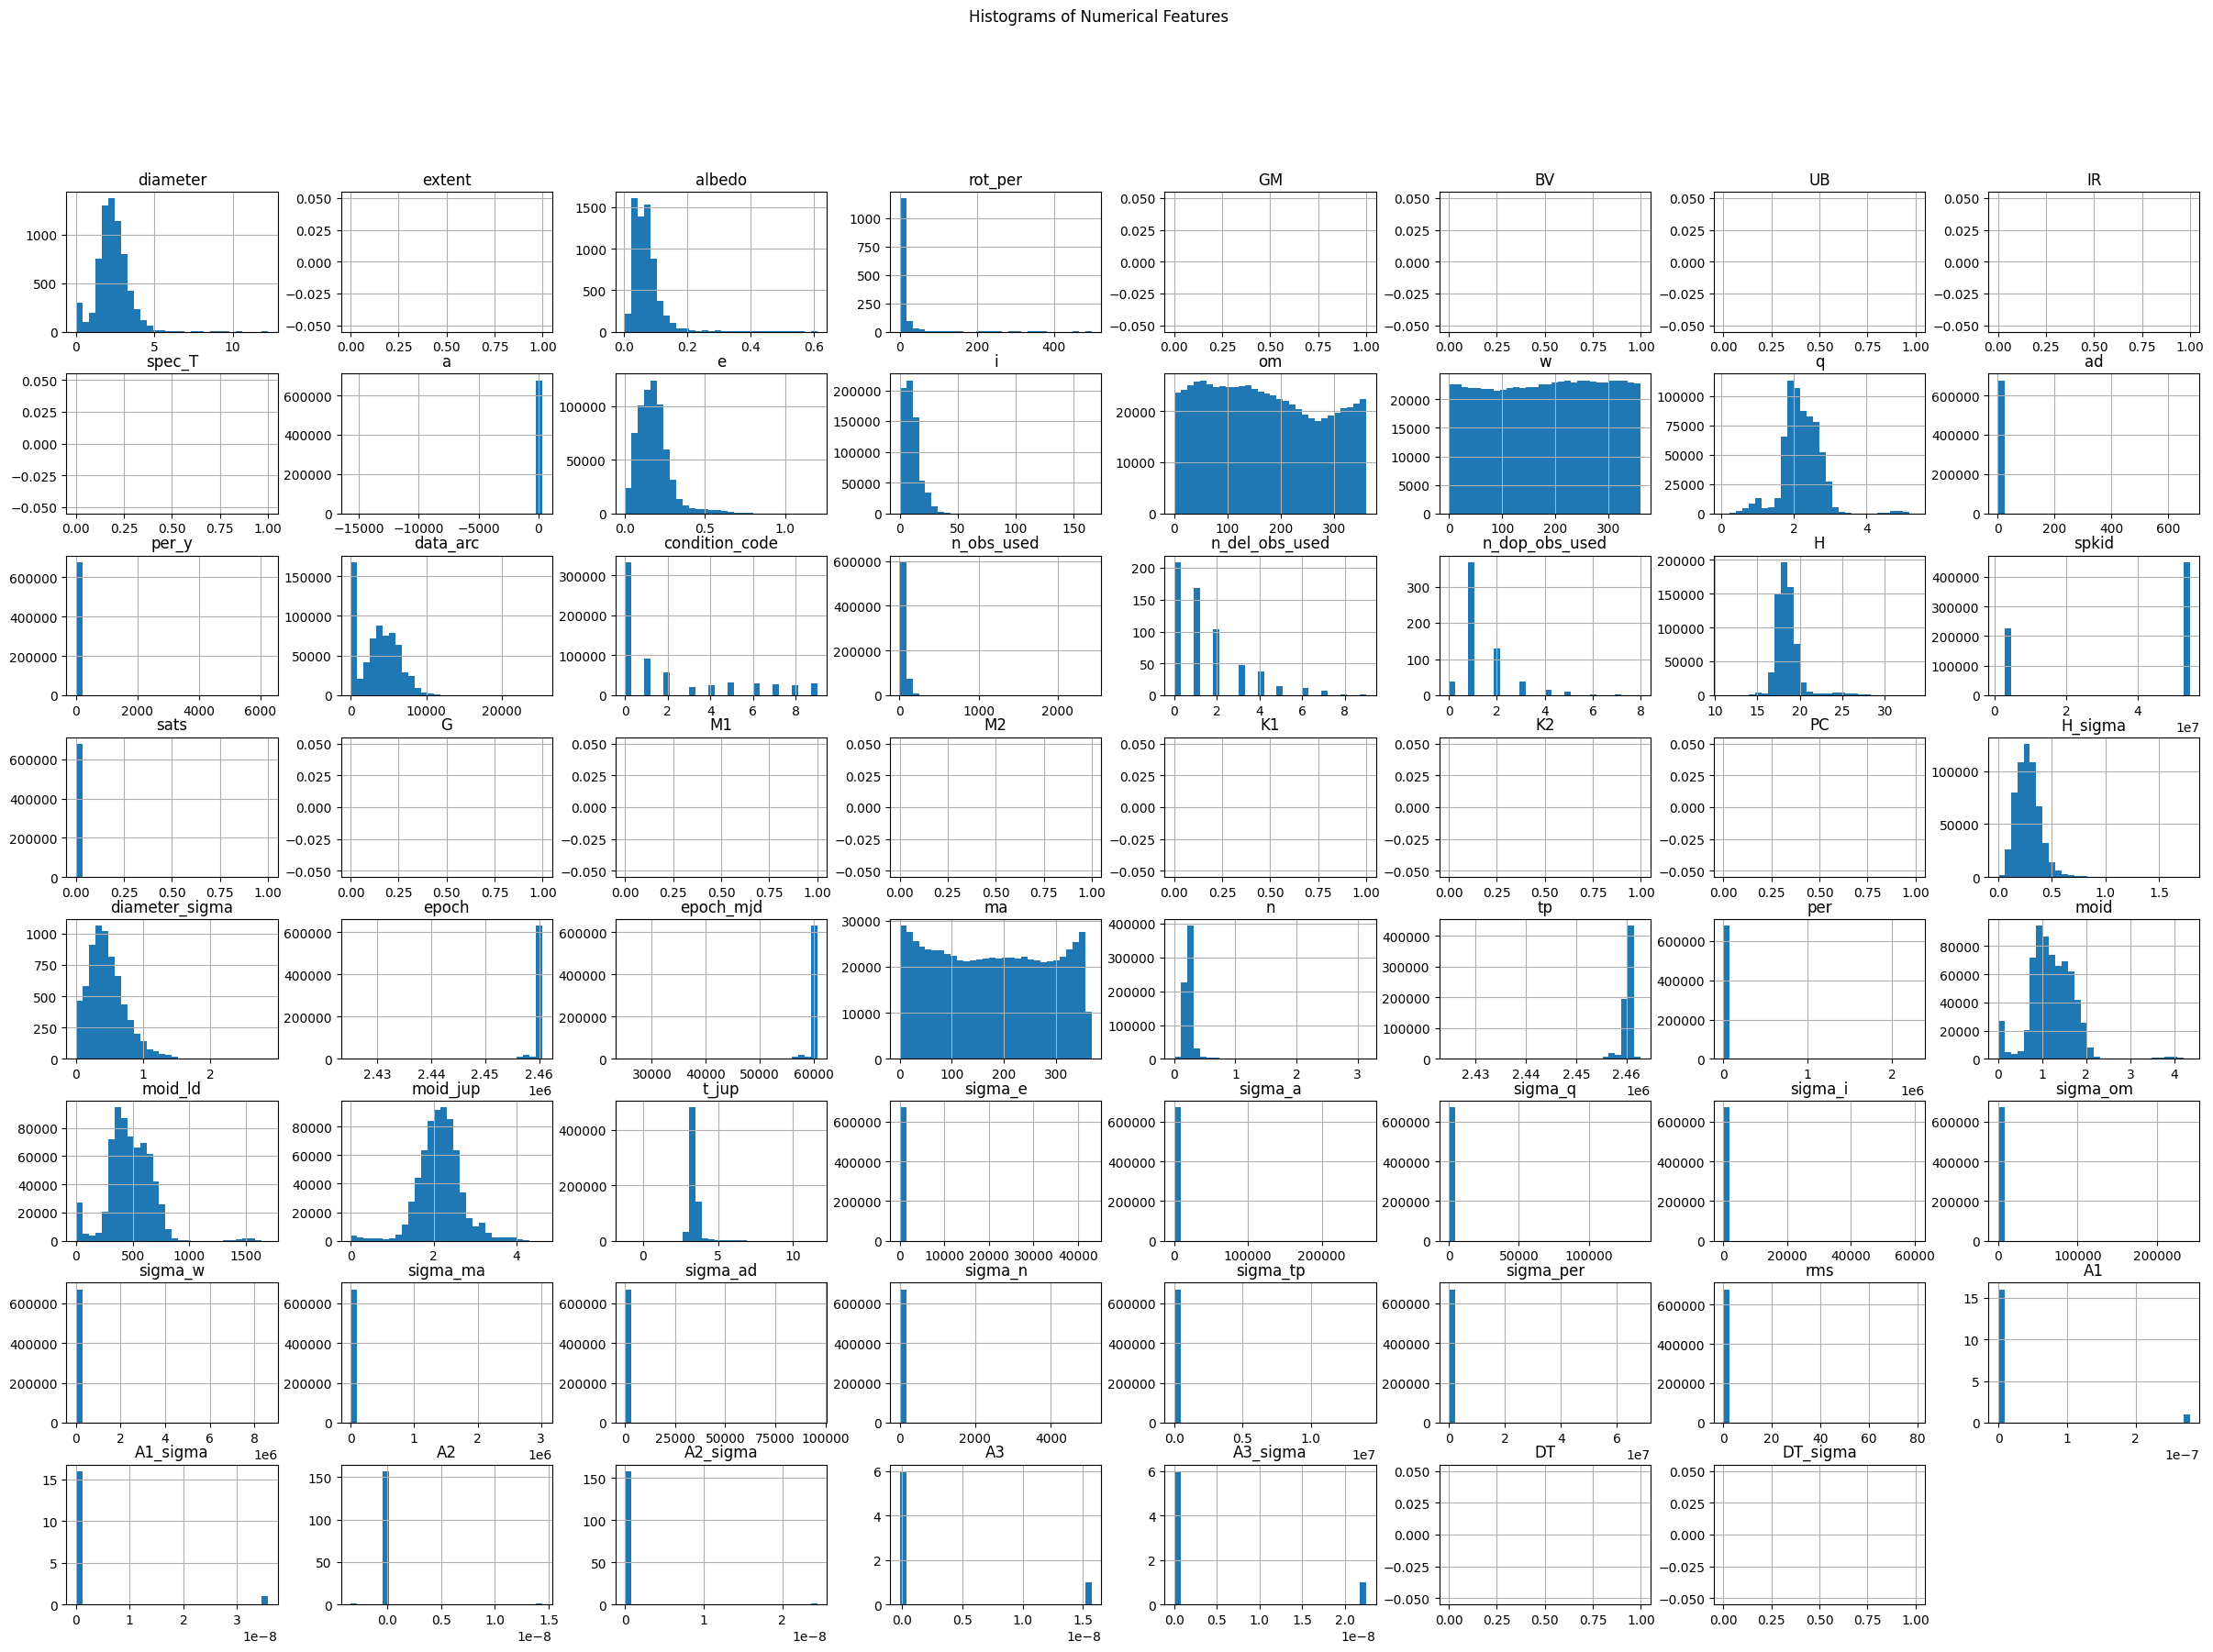

In [5]:
def eda_report(df, target_column=None):
    """
    Generates an EDA report for the given DataFrame.
    """
    print("### Dataset Summary ###\n")
    print(f"Shape of Dataset: {df.shape}")
    print("\nMissing Values:\n", df.isnull().sum())
    print("\nDuplicate Rows: ", df.duplicated().sum())

    print("\n### Descriptive Statistics ###\n")
    print("Numerical Columns Summary:\n", df.describe())
    if not df.select_dtypes(include=['object', 'category']).empty:
        print("\nCategorical Columns Summary:\n", df.describe(include=['object', 'category']))

    # Distribution of numerical features
    print("\n### Data Distribution ###\n")
    df.hist(bins=30, figsize=(30, 20))
    plt.suptitle("Histograms of Numerical Features")
    plt.show()

eda_report(df)


In [6]:
# Statistical Summary of Numeric Columns
print("\nStatistical Summary of Numeric Columns:")
display(df.describe(include=[np.number]))


Statistical Summary of Numeric Columns:


diameter  extent       albedo      rot_per   GM   BV   UB   IR  \
count  6866.000000     0.0  6500.000000  1347.000000  0.0  0.0  0.0  0.0   
mean      2.314770     NaN     0.072598    10.543591  NaN  NaN  NaN  NaN   
std       0.962663     NaN     0.050526    33.425895  NaN  NaN  NaN  NaN   
min       0.002500     NaN     0.004000     0.000832  NaN  NaN  NaN  NaN   
25%       1.760000     NaN     0.042000     0.247800  NaN  NaN  NaN  NaN   
50%       2.275500     NaN     0.065000     3.123000  NaN  NaN  NaN  NaN   
75%       2.853000     NaN     0.087000     7.995000  NaN  NaN  NaN  NaN   
max      12.257000     NaN     0.609000   497.967000  NaN  NaN  NaN  NaN   

       spec_T              a  ...     sigma_per            rms            A1  \
count     0.0  677494.000000  ...  6.711400e+05  677493.000000  1.700000e+01   
mean      NaN       2.657485  ...  4.414169e+02       0.542976  1.657030e-08   
std       NaN      19.060361  ...  1.159251e+05       0.218464  6.763313e-08   
min       NaN  -15675.358600  ...  1.354900e-07       0.000002 -8.298571e-10   
25%       NaN       2.386966  ...  3.904600e-05       0.480590  5.604737e-11   
50%       NaN       2.662342  ...  1.069100e-04       0.559640  7.443995e-11   
75%       NaN       3.031284  ...  1.409250e-02       0.630140  1.599229e-10   
max       NaN     338.924933  ...  6.852400e+07      79.205000  2.790193e-07   

           A1_sigma            A2      A2_sigma            A3      A3_sigma  \
count  1.700000e+01  1.590000e+02  1.590000e+02  7.000000e+00  7.000000e+00   
mean   2.187895e-09  6.890860e-11  1.557729e-10  2.224416e-09  3.217886e-09   
std    8.648199e-09  1.175754e-09  1.938988e-09  5.960094e-09  8.498205e-09   
min    2.503000e-12 -3.383309e-09  1.050000e-15 -2.026389e-10  1.121000e-12   
25%    1.108000e-11 -2.260412e-13  1.384000e-14 -1.961019e-11  2.366000e-12   
50%    2.168000e-11 -1.189060e-13  2.389000e-14 -1.298996e-11  3.947000e-12   
75%    5.822000e-11 -4.797074e-14  4.812500e-14  4.326784e-11  1.270050e-11   
max    3.574000e-08  1.441264e-08  2.445000e-08  1.573923e-08  2.249000e-08   

        DT  DT_sigma  
count  0.0       0.0  
mean   NaN       NaN  
std    NaN       NaN  
min    NaN       NaN  
25%    NaN       NaN  
50%    NaN       NaN  
75%    NaN       NaN  
max    NaN       NaN  

[8 rows x 63 columns]


Missing Data Summary (Percentage of Missing Values):


DT_sigma     100.0
extent       100.0
G            100.0
M1           100.0
GM           100.0
             ...  
epoch_cal      0.0
equinox        0.0
ma             0.0
tp_cal         0.0
spkid          0.0
Length: 79, dtype: float64

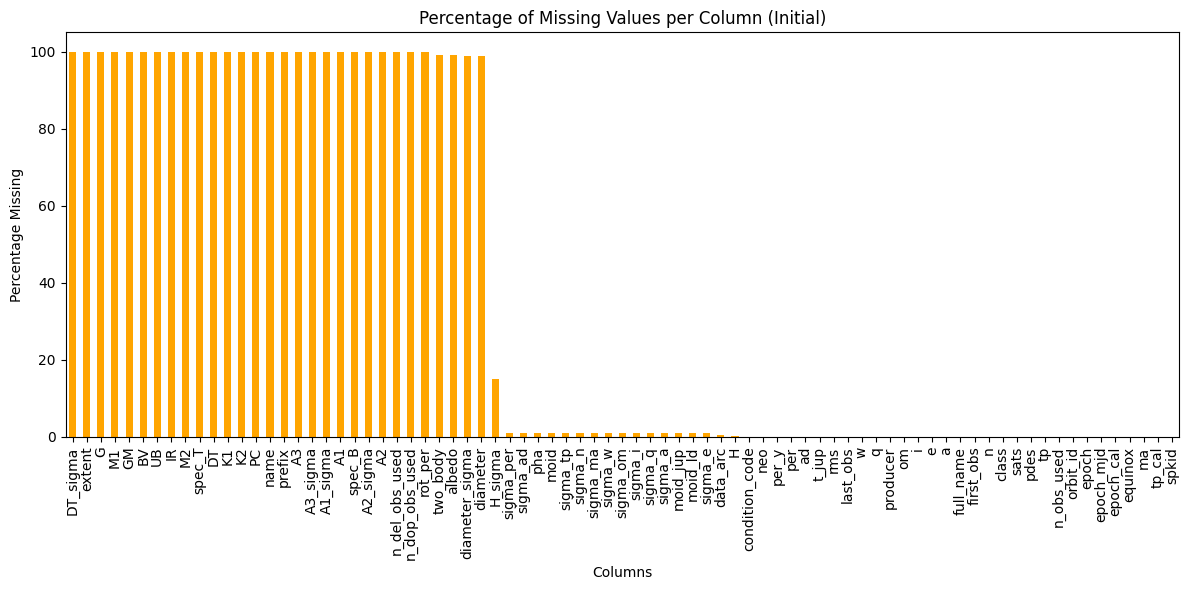

In [7]:
# Missing Values Summary
missing_summary = df.isnull().mean().sort_values(ascending=False) * 100
print("\nMissing Data Summary (Percentage of Missing Values):")
display(missing_summary)

# Plot Missing Values
plt.figure(figsize=(12,6))
missing_summary.plot(kind='bar', color='orange')
plt.title('Percentage of Missing Values per Column (Initial)')
plt.xlabel('Columns')
plt.ylabel('Percentage Missing')
plt.tight_layout()
plt.show()

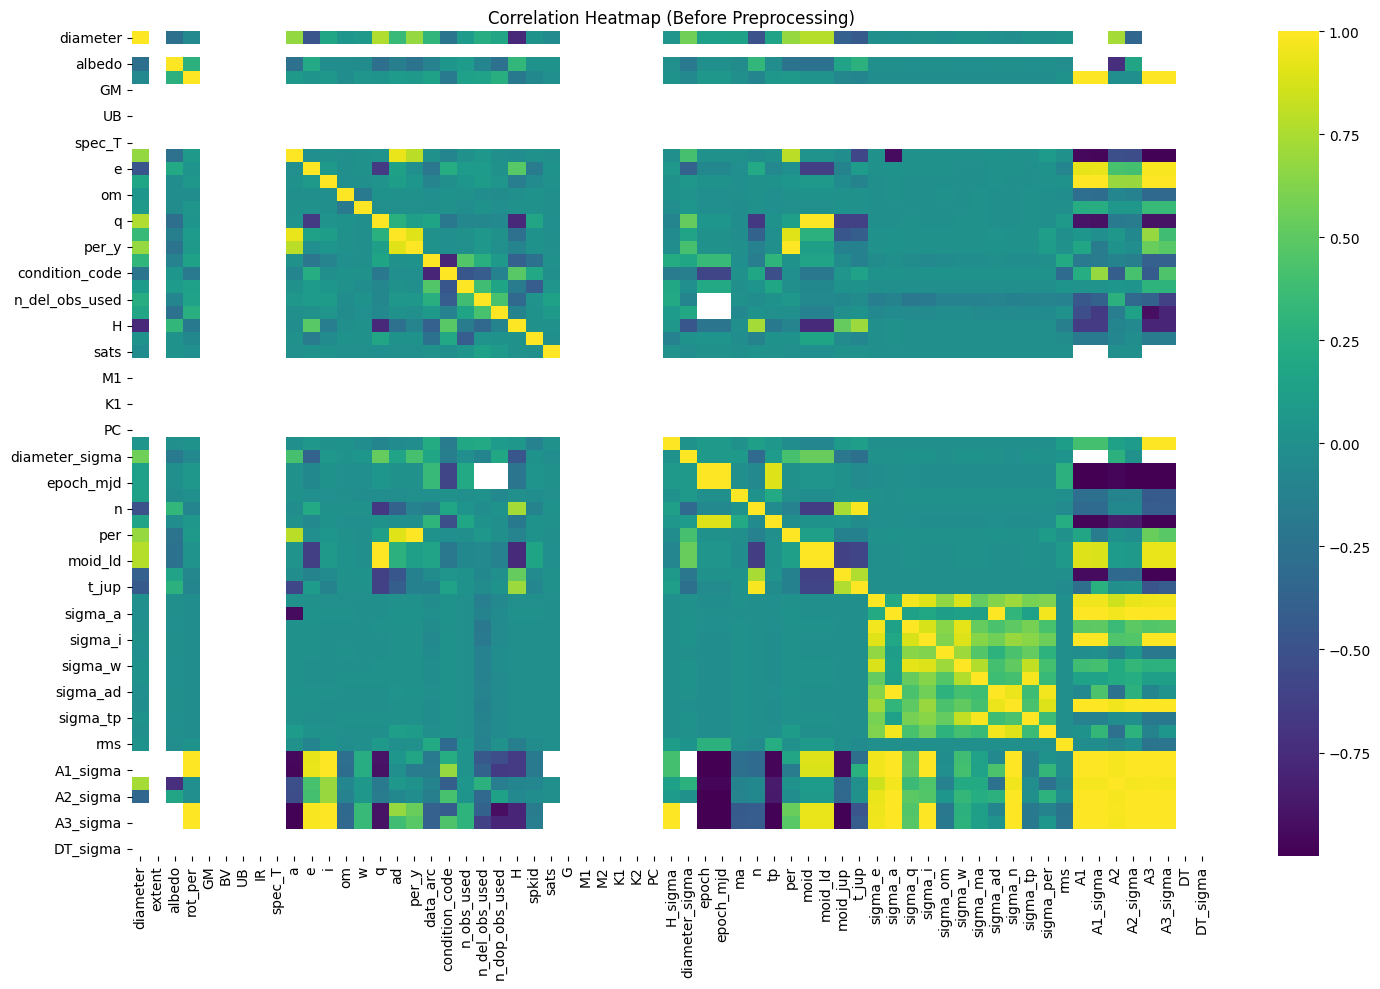

In [8]:
# Correlation Heatmap (Initial)
numeric_cols_initial = df.select_dtypes(include=[np.number]).columns
corr_initial = df[numeric_cols_initial].corr()
plt.figure(figsize=(15,10))
sns.heatmap(corr_initial, annot=False, cmap='viridis')
plt.title('Correlation Heatmap (Before Preprocessing)')
plt.tight_layout()
plt.show()

# 4.Data Preprocessing

## 4.1. Handle Missing Data

In [9]:
# Recalculate missing_summary after initial EDA
missing_summary = df.isnull().mean().sort_values(ascending=False) * 100
missing_summary = missing_summary[missing_summary > 0]
print("\nMissing Data Summary (Percentage of Missing Values):")
display(missing_summary)

# Drop columns with >90% missing values
cols_to_drop_missing = missing_summary[missing_summary > 90].index.tolist()
irrelevant_columns = ['producer', 'equinox', 'orbit_id', 'pdes', 'full_name', 'name', 'prefix']
cols_to_drop = list(set(cols_to_drop_missing + irrelevant_columns))

# Ensure columns exist before dropping
cols_to_drop = [col for col in cols_to_drop if col in df.columns]

df.drop(columns=cols_to_drop, inplace=True, errors='ignore')
print("\nDropped Columns:")
print(cols_to_drop)
logging.info(f"Dropped columns: {cols_to_drop}")

# Impute missing values in numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
imputer = SimpleImputer(strategy='mean')
df[numeric_cols] = imputer.fit_transform(df[numeric_cols])
logging.info("Missing values imputed using mean strategy.")


Missing Data Summary (Percentage of Missing Values):


DT_sigma          100.000000
extent            100.000000
G                 100.000000
M1                100.000000
GM                100.000000
BV                100.000000
UB                100.000000
IR                100.000000
M2                100.000000
spec_T            100.000000
DT                100.000000
K1                100.000000
K2                100.000000
PC                100.000000
name               99.999852
prefix             99.999410
A3                 99.998967
A3_sigma           99.998967
A1_sigma           99.997491
A1                 99.997491
spec_B             99.992620
A2_sigma           99.976531
A2                 99.976531
n_del_obs_used     99.910700
n_dop_obs_used     99.910700
rot_per            99.801179
two_body           99.062427
albedo             99.040582
diameter_sigma     98.987002
diameter           98.986559
H_sigma            15.064635
sigma_per           0.937868
sigma_ad            0.937868
pha                 0.937720
moid                0.937573
sigma_tp            0.937573
sigma_n             0.937573
sigma_ma            0.937573
sigma_w             0.937573
sigma_om            0.937573
sigma_i             0.937573
sigma_q             0.937573
sigma_a             0.937573
moid_jup            0.937573
moid_ld             0.937573
sigma_e             0.937573
data_arc            0.392771
H                   0.146717
condition_code      0.001033
neo                 0.000295
per_y               0.000295
per                 0.000295
ad                  0.000295
t_jup               0.000295
rms                 0.000148
dtype: float64


Dropped Columns:
['A2', 'BV', 'producer', 'K2', 'prefix', 'PC', 'A1', 'two_body', 'A3_sigma', 'A3', 'equinox', 'DT_sigma', 'DT', 'A2_sigma', 'n_dop_obs_used', 'IR', 'extent', 'diameter', 'M1', 'n_del_obs_used', 'K1', 'spec_B', 'A1_sigma', 'M2', 'full_name', 'UB', 'diameter_sigma', 'orbit_id', 'rot_per', 'G', 'pdes', 'spec_T', 'name', 'albedo', 'GM']


## 4.2. Encode Binary Columns

In [10]:
# Map 'Y'/'N' to 1/0 in binary columns
binary_mapping = {'Y': 1, 'N': 0}
for col in ['neo', 'pha']:
    if col in df.columns:
        df[col] = df[col].map(binary_mapping)
        logging.info(f"Binary mapping applied to column: {col}")

## 4.3. Handle Date Columns

In [11]:
# Handle date columns
date_cols = ['epoch_cal', 'tp_cal', 'first_obs', 'last_obs']
for col in date_cols:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors='coerce', format='%Y-%m-%d')
        df[f'{col}_year'] = df[col].dt.year
        df[f'{col}_month'] = df[col].dt.month
        df[f'{col}_day'] = df[col].dt.day
        df.drop(columns=[col], inplace=True)
        logging.info(f"Date column processed: {col}")

## 4.4. One-Hot Encode Categorical Columns

In [12]:
# One-hot encode categorical columns
remaining_categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
print("\nRemaining Categorical Columns after Date conversion:", remaining_categorical_cols)

# One-hot encode the 'class'
if 'class' in df.columns:
    df = pd.get_dummies(df, columns=['class'], prefix='class', drop_first=True)
    logging.info("One-hot encoding applied to 'class' column.")


Remaining Categorical Columns after Date conversion: ['class']


# 5.Feature Engineering

## 5.1. Add Derived Features

In [13]:
GRAVITATIONAL_CONSTANT = 39.478  # AU^3 / yr^2

if all(col in df.columns for col in ['q', 'a', 'e']):
    df['relative_orbital_distance'] = np.abs(df['q'] - df['a'] * (1 - df['e']))
    logging.info("Derived feature 'relative_orbital_distance' added.")
else:
    logging.warning("Required columns for 'relative_orbital_distance' not found.")

if 'a' in df.columns:
    df['orbital_velocity'] = np.sqrt(GRAVITATIONAL_CONSTANT / df['a'])
    logging.info("Derived feature 'orbital_velocity' added.")
else:
    logging.warning("Column 'a' not found. 'orbital_velocity' not created.")

if all(col in df.columns for col in ['e', 'a', 'q']):
    df['adjusted_eccentricity'] = df['e'] * df['a'] / df['q']
    logging.info("Derived feature 'adjusted_eccentricity' added.")
else:
    logging.warning("Required columns for 'adjusted_eccentricity' not found.")

## 5.2. Create Target Variable

In [14]:
# Create target variable
if 'moid' in df.columns:
    df['collision_risk'] = np.where(df['moid'] < 0.05, 1, 0)
    logging.info("'collision_risk' target variable created based on 'moid'.")

    # Drop 'moid' and 'moid_ld' to prevent data leakage
    features_to_drop = ['moid', 'moid_ld']
    features_to_drop = [col for col in features_to_drop if col in df.columns]
    df.drop(columns=features_to_drop, inplace=True, errors='ignore')
    logging.info(f"Dropped columns after target creation: {features_to_drop}")
else:
    logging.error("'moid' column not found. Cannot create 'collision_risk' target variable.")
    raise KeyError("'moid' column is missing from the dataset.")

# 6.Data Preparation

## 6.1. Define Features and Target

In [15]:
# Define Features and Target
X = df.drop(columns=['collision_risk'])
y = df['collision_risk']

# Ensure only numeric features are used
X = X.select_dtypes(include=[np.number])
logging.info("Defined feature matrix X and target vector y.")

## 6.2. Split the Dataset

In [16]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_SEED, stratify=y
)
logging.info("Data split into training and testing sets.")

## 6.3. Handle Missing Values in Training and Testing Sets

In [17]:
# Identify and drop columns with all missing values
cols_to_drop = X_train.columns[X_train.isnull().all()]
print(f"Columns with all missing values: {cols_to_drop.tolist()}")

X_train = X_train.drop(columns=cols_to_drop)
X_test = X_test.drop(columns=cols_to_drop)

# Impute missing values for numerical columns
imputer = SimpleImputer(strategy='mean')
X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

# Impute missing values for binary columns
binary_imputer = SimpleImputer(strategy='most_frequent')
for col in ['neo', 'pha']:
    if col in X_train.columns:
        X_train[col] = binary_imputer.fit_transform(X_train[[col]])
        X_test[col] = binary_imputer.transform(X_test[[col]])

# Verify no missing values remain
print("Missing Values in X_train:", X_train.isnull().sum().sum())
print("Missing Values in X_test:", X_test.isnull().sum().sum())

Columns with all missing values: ['epoch_cal_year', 'epoch_cal_month', 'epoch_cal_day', 'tp_cal_year', 'tp_cal_month', 'tp_cal_day']
Missing Values in X_train: 0
Missing Values in X_test: 0


## 6.4. Handle Class Imbalance with SMOTE

In [18]:
# Handle class imbalance with SMOTE
smote = SMOTE(random_state=RANDOM_SEED)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
logging.info("Applied SMOTE to balance classes in the training set.")

print("Resampled Training Set Shape:", X_train_resampled.shape)

Resampled Training Set Shape: (1054508, 46)


## 6.5. Data Scaling

In [19]:
# Data Scaling
scaler = StandardScaler()
X_train_resampled_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)
logging.info("Data scaling applied using StandardScaler.")

# Saving Scaler for future use
scaler_path = os.path.join(SAVE_DIR, "scaler.pkl")
joblib.dump(scaler, scaler_path)
logging.info(f"Scaler saved to: {scaler_path}")

## 6.6 Save feature names

In [20]:
# Save Feature Names
feature_names = X_train_resampled.columns.tolist()
feature_names_path = os.path.join(SAVE_DIR, "feature_names.pkl")
joblib.dump(feature_names, feature_names_path)
logging.info(f"Feature names saved to: {feature_names_path}")

In [21]:
# Load feature names to verify
loaded_feature_names = joblib.load(feature_names_path)
print("Loaded Feature Names:", loaded_feature_names[:10], "...")

Loaded Feature Names: ['a', 'e', 'i', 'om', 'w', 'q', 'ad', 'per_y', 'data_arc', 'condition_code'] ...


# 7.Secondary Exploratory Data Analysis (Post-Preprocessing)

In [22]:
# Dataset Shape
print(f"Dataset Shape: {df.shape}\n")

# Summary Statistics
print("Summary Statistics for Numeric Columns:")
print(df.describe())
print("\n")

Dataset Shape: (677494, 62)

Summary Statistics for Numeric Columns:
                   a              e              i             om  \
count  677494.000000  677494.000000  677494.000000  677494.000000   
mean        2.657485       0.179969      10.108873     171.123621   
std        19.060361       0.105446       6.902369     103.660492   
min    -15675.358600       0.000179       0.005985       0.000380   
25%         2.386966       0.108563       4.828067      81.599919   
50%         2.662342       0.168357       8.874724     164.148162   
75%         3.031284       0.225410      13.713292     258.347100   
max       338.924933       1.201134     165.592677     359.999838   

                   w              q             ad          per_y  \
count  677494.000000  677494.000000  677494.000000  677494.000000   
mean      181.977018       2.208482       3.152778       4.457621   
std       104.005915       0.533043       1.155962       8.381619   
min         0.000012       0.0704

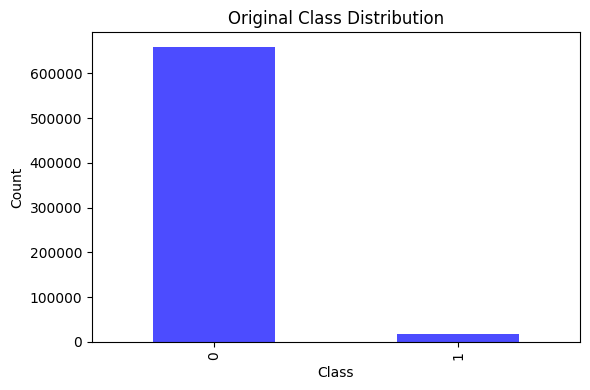

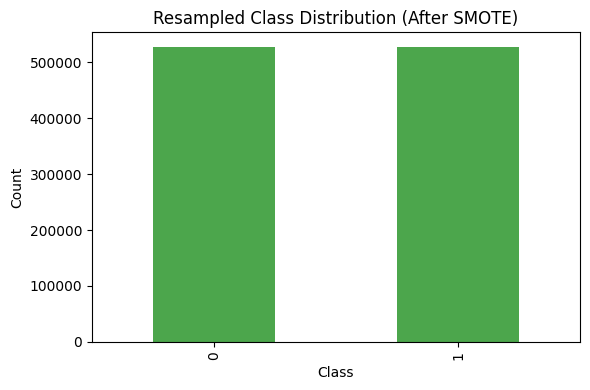

In [23]:
# Original class distribution
plt.figure(figsize=(6, 4))
y.value_counts().plot(kind='bar', color='blue', alpha=0.7)
plt.title('Original Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Resampled class distribution
plt.figure(figsize=(6, 4))
y_train_resampled.value_counts().plot(kind='bar', color='green', alpha=0.7)
plt.title('Resampled Class Distribution (After SMOTE)')
plt.xlabel('Class')
plt.ylabel('Count')
plt.tight_layout()
plt.show()


In [24]:
#Class distribution and shape(After Preprocessing & Resampling)
print("Class Distribution in y_train_resampled:\n", y_train_resampled.value_counts())
print("Post-Preprocessing X_train_resampled_scaled shape:", X_train_resampled_scaled.shape)

Class Distribution in y_train_resampled:
 collision_risk
0    527254
1    527254
Name: count, dtype: int64
Post-Preprocessing X_train_resampled_scaled shape: (1054508, 46)


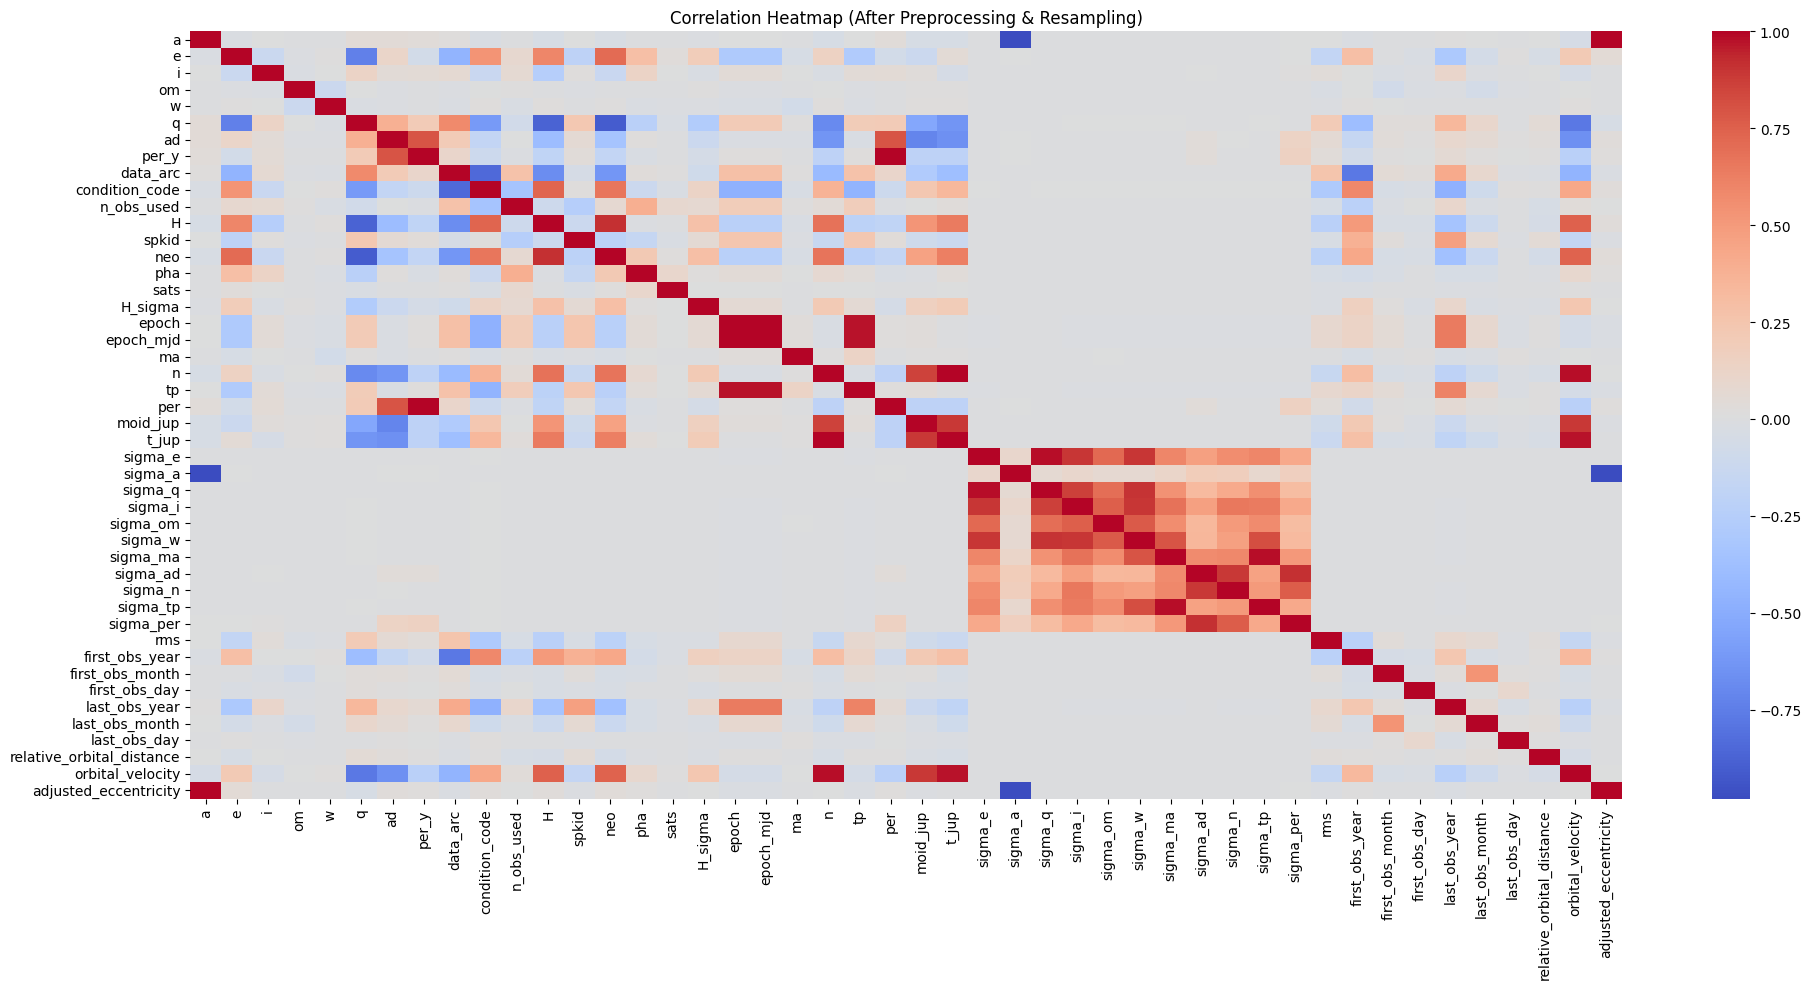

In [25]:
# Correlation Heatmap (After Preprocessing & Resampling)
X_train_post = pd.DataFrame(X_train_resampled_scaled, columns=X_train.columns)
corr_post = X_train_post.corr()
plt.figure(figsize=(20,10))
sns.heatmap(corr_post, annot=False, cmap='coolwarm')
plt.title('Correlation Heatmap (After Preprocessing & Resampling)')
plt.tight_layout()
plt.show()

Summary Statistics for Orbital Features:

                   a              e              i              q  \
count  677494.000000  677494.000000  677494.000000  677494.000000   
mean        2.657485       0.179969      10.108873       2.208482   
std        19.060361       0.105446       6.902369       0.533043   
min    -15675.358600       0.000179       0.005985       0.070431   
25%         2.386966       0.108563       4.828067       1.912987   
50%         2.662342       0.168357       8.874724       2.183478   
75%         3.031284       0.225410      13.713292       2.535423   
max       338.924933       1.201134     165.592677       5.346342   

       relative_orbital_distance  
count               6.774940e+05  
mean                2.327566e-10  
std                 2.768647e-09  
min                 0.000000e+00  
25%                 0.000000e+00  
50%                 4.440892e-16  
75%                 4.440892e-16  
max                 4.998696e-08  




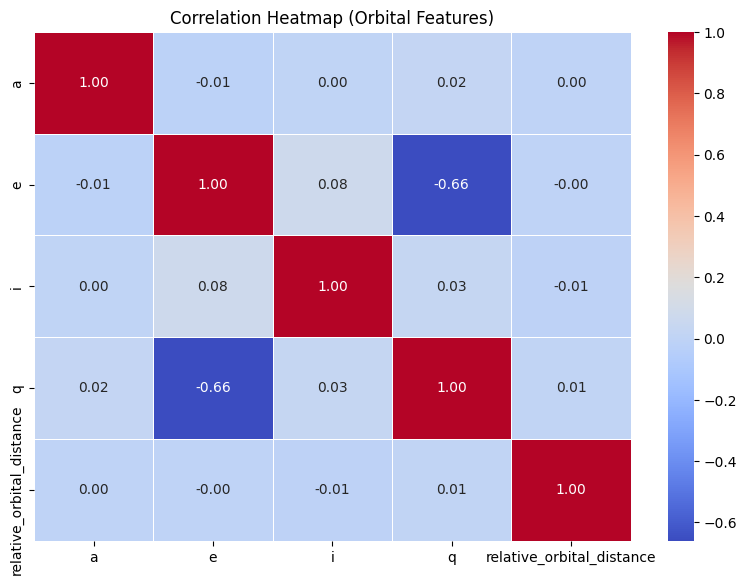

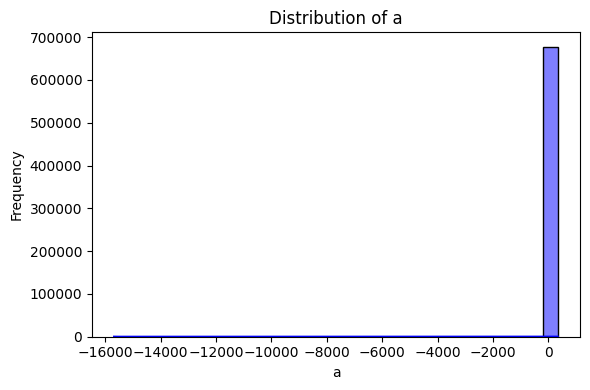

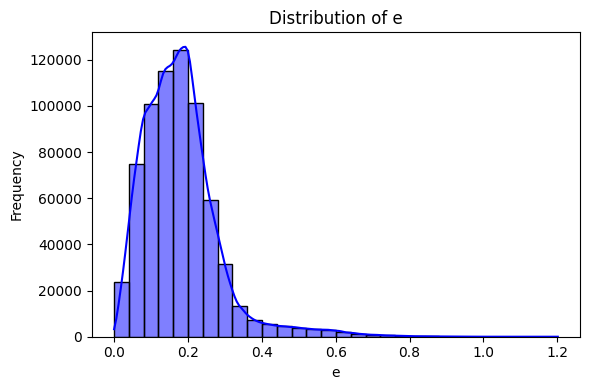

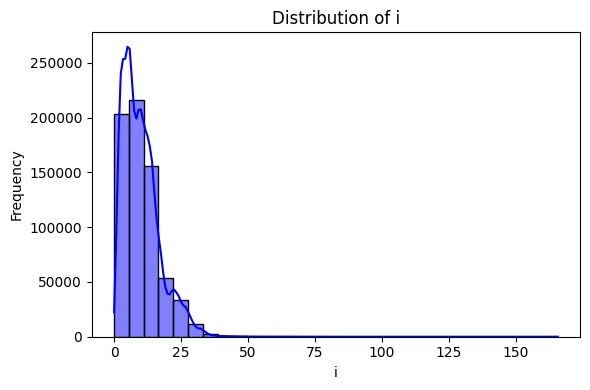

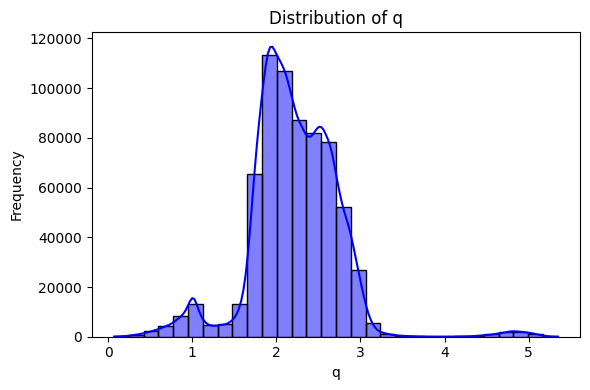

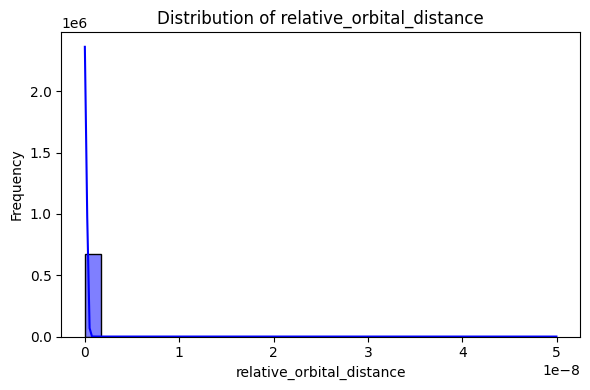

Pairplot for Orbital Features:


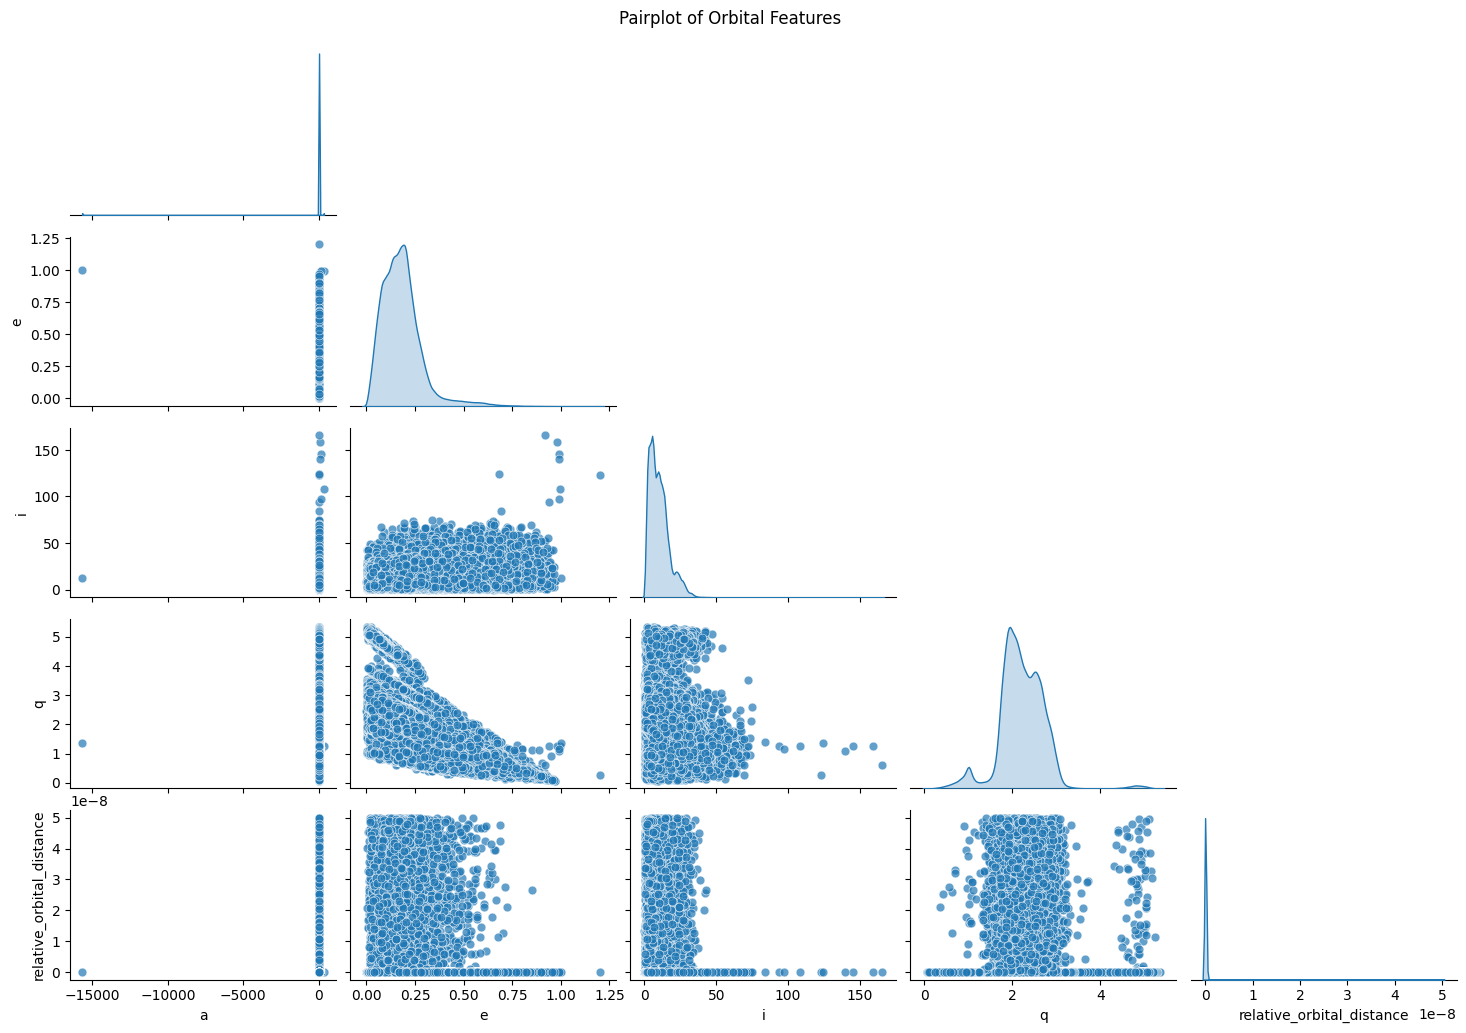

In [26]:
def orbital_features_eda(df, features):

    # Filter for the specific features
    features = [f for f in features if f in df.columns]
    if not features:
        print("None of the specified features are present in the dataset.")
        return

    # Summary statistics
    print("Summary Statistics for Orbital Features:\n")
    print(df[features].describe())
    print("\n")

    # Correlation Heatmap
    plt.figure(figsize=(8, 6))
    corr = df[features].corr()
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
    plt.title('Correlation Heatmap (Orbital Features)')
    plt.tight_layout()
    plt.show()

    # Distribution and KDE Plots for Each Feature
    for feature in features:
     plt.figure(figsize=(6, 4))
     sns.histplot(df[feature], kde=True, bins=30, color='blue')
     plt.title(f'Distribution of {feature}')
     plt.xlabel(feature)
     plt.ylabel('Frequency')
     plt.tight_layout()
     plt.show()

    # Pairplot
    print("Pairplot for Orbital Features:")
    pairplot = sns.pairplot(
        df[features],
        diag_kind='kde',
        corner=True,
        plot_kws={'alpha': 0.7, 's': 40},
        diag_kws={'shade': True},
        palette='viridis'
    )
    pairplot.fig.suptitle("Pairplot of Orbital Features", y=1.02)
    pairplot.fig.set_size_inches(15, 10)
    plt.show()

orbital_features = ['a', 'e', 'i', 'q', 'moid', 'relative_orbital_distance']
orbital_features_eda(df, orbital_features)

logging.info("Done EDA for orbital dynamics features.")

# 8.Model Training and Evaluation

## 8.1 Random Forest Classifier

### 8.1.1 Training Random Forest

In [32]:
# Model save path
rf_model_path = os.path.join(SAVE_DIR, "random_forest_model.pkl")

# Train Random Forest
rf_model = RandomForestClassifier(
    n_estimators=100,
    random_state=RANDOM_SEED,
    n_jobs=-1
)
rf_model.fit(X_train_resampled_scaled, y_train_resampled)

# Save the model
joblib.dump(rf_model, rf_model_path)
print(f"Random Forest model saved at: {rf_model_path}")
logging.info(f"Random Forest model saved at: {rf_model_path}")

Random Forest model saved at: /content/drive/My Drive/Predictive_Modeling_for_Asteroid_Collision_Risk_Using_Machine_Learning_and_Orbital_Dynamics/random_forest_model.pkl


### 8.1.2 Evaluate the Model

In [33]:
# Predictions and Evaluation for Random Forest
rf_y_pred = rf_model.predict(X_test_scaled)
rf_y_prob = rf_model.predict_proba(X_test_scaled)[:, 1]

rf_accuracy = accuracy_score(y_test, rf_y_pred)
rf_f1 = f1_score(y_test, rf_y_pred)
rf_precision = precision_score(y_test, rf_y_pred)
rf_recall = recall_score(y_test, rf_y_pred)
rf_roc_auc = roc_auc_score(y_test, rf_y_prob)

print("\nRandom Forest Evaluation Metrics:")
print(f"Accuracy: {rf_accuracy:.4f}")
print(f"F1 Score: {rf_f1:.4f}")
print(f"Precision: {rf_precision:.4f}")
print(f"Recall: {rf_recall:.4f}")
print(f"ROC-AUC: {rf_roc_auc:.4f}")
logging.info("Random Forest evaluation completed.")


Random Forest Evaluation Metrics:
Accuracy: 0.9951
F1 Score: 0.9164
Precision: 0.8548
Recall: 0.9875
ROC-AUC: 0.9992


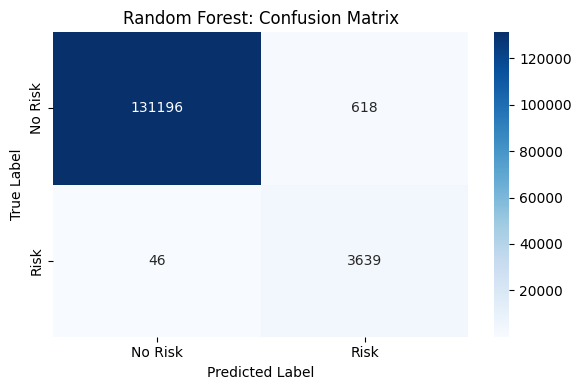

In [34]:
# Confusion Matrix for Random Forest
conf_matrix_rf = confusion_matrix(y_test, rf_y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Risk', 'Risk'], yticklabels=['No Risk', 'Risk'])
plt.title('Random Forest: Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

## 8.2 XGBoost Classifier

### 8.2.1 Training XGBoost

In [35]:
# model save path
xgb_model_path = os.path.join(SAVE_DIR, "xgboost_model.pkl")

# Evaluation Set
eval_set = [(X_train_resampled_scaled, y_train_resampled), (X_test_scaled, y_test)]

# Train XGBoost with Evaluation Metrics
xgb_model = XGBClassifier(
    use_label_encoder=False,
    random_state=RANDOM_SEED,
    eval_metric='logloss',  # Track LogLoss
    n_estimators=500
)
xgb_model.fit(
    X_train_resampled_scaled, y_train_resampled,
    eval_set=eval_set,
    verbose=False  # Disable verbose output
)

logging.info("XGBoost model trained.")

# Save model
joblib.dump(xgb_model, xgb_model_path)
print(f"XGBoost model saved at: {xgb_model_path}")
logging.info(f"XGBoost model saved at: {xgb_model_path}")

XGBoost model saved at: /content/drive/My Drive/Predictive_Modeling_for_Asteroid_Collision_Risk_Using_Machine_Learning_and_Orbital_Dynamics/xgboost_model.pkl


### 8.2.2 Evaluate the Model

In [36]:
# Predictions and Evaluation for XGBoost
xgb_y_pred = xgb_model.predict(X_test_scaled)
xgb_y_prob = xgb_model.predict_proba(X_test_scaled)[:, 1]

xgb_accuracy = accuracy_score(y_test, xgb_y_pred)
xgb_f1 = f1_score(y_test, xgb_y_pred)
xgb_precision = precision_score(y_test, xgb_y_pred)
xgb_recall = recall_score(y_test, xgb_y_pred)
xgb_roc_auc = roc_auc_score(y_test, xgb_y_prob)

print("\nXGBoost Evaluation Metrics:")
print(f"Accuracy: {xgb_accuracy:.4f}")
print(f"F1 Score: {xgb_f1:.4f}")
print(f"Precision: {xgb_precision:.4f}")
print(f"Recall: {xgb_recall:.4f}")
print(f"ROC-AUC: {xgb_roc_auc:.4f}")
logging.info("XGBoost evaluation completed.")


XGBoost Evaluation Metrics:
Accuracy: 0.9971
F1 Score: 0.9473
Precision: 0.9275
Recall: 0.9680
ROC-AUC: 0.9997


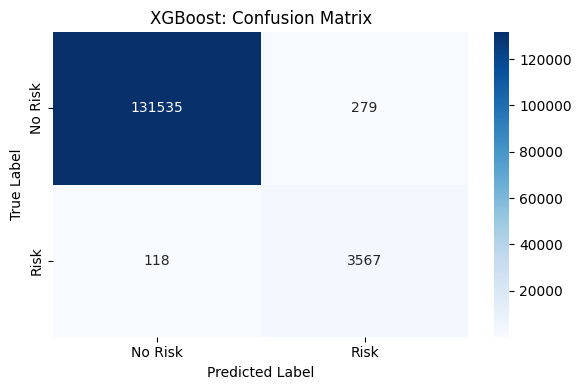

In [37]:
# Confusion Matrix for XGBoost
conf_matrix_xgb = confusion_matrix(y_test, xgb_y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix_xgb, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Risk', 'Risk'], yticklabels=['No Risk', 'Risk'])
plt.title('XGBoost: Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

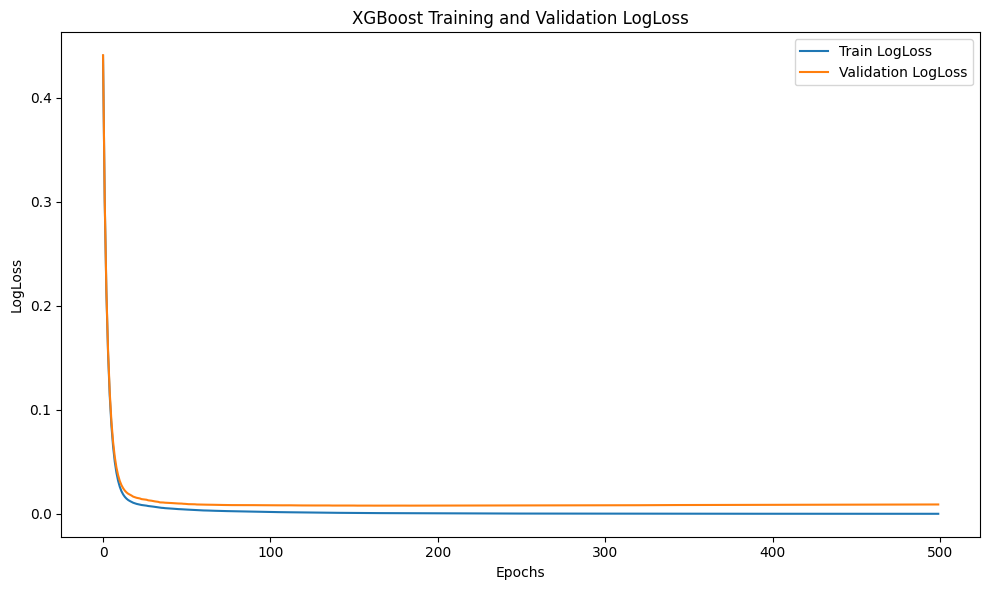

In [38]:
# Extract Evaluation Metrics
results = xgb_model.evals_result()

# Plot Training and Validation LogLoss
plt.figure(figsize=(10, 6))
plt.plot(results['validation_0']['logloss'], label='Train LogLoss')
plt.plot(results['validation_1']['logloss'], label='Validation LogLoss')
plt.title('XGBoost Training and Validation LogLoss')
plt.xlabel('Epochs')
plt.ylabel('LogLoss')
plt.legend()
plt.tight_layout()
plt.show()

## 8.3 Custom Neural Network(Dense)

### 8.3.1 Define the Model

In [39]:
# Model save path
dense_model_filename = os.path.join(SAVE_DIR, "dense_model.h5")

def create_dense_model(input_dim):
    """
    Creates and compiles a custom neural network model.

    Parameters:
    - input_dim (int): Number of input features.

    Returns:
    - model (Sequential): Compiled Keras model.
    """
    model = Sequential([
        Dense(128, activation='relu', input_dim=input_dim),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')  # Binary classification
    ])
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

dense_model = create_dense_model(X_train_resampled_scaled.shape[1])

### 8.3.2 Training Neural Network

In [40]:
print("\nTraining Custom Neural Network...")

# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = dense_model.fit(
    X_train_resampled_scaled,
    y_train_resampled,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)
logging.info("Custom Neural Network trained.")

# Save Neural Network model
dense_model.save(dense_model_filename)
print(f"Neural Network model saved to: {dense_model_filename}")
logging.info(f"Neural Network model saved to: {dense_model_filename}")


Training Custom Neural Network...
Epoch 1/20
26363/26363 ━━━━━━━━━━━━━━━━━━━━ 46s 2ms/step - accuracy: 0.9910 - loss: 0.0305 - val_accuracy: 0.9994 - val_loss: 0.0080
Epoch 2/20
26363/26363 ━━━━━━━━━━━━━━━━━━━━ 42s 2ms/step - accuracy: 0.9950 - loss: 0.0174 - val_accuracy: 0.9999 - val_loss: 0.0059
Epoch 3/20
26363/26363 ━━━━━━━━━━━━━━━━━━━━ 41s 2ms/step - accuracy: 0.9955 - loss: 0.0234 - val_accuracy: 0.9999 - val_loss: 0.0056
Epoch 4/20
26363/26363 ━━━━━━━━━━━━━━━━━━━━ 41s 2ms/step - accuracy: 0.9956 - loss: 0.0157 - val_accuracy: 0.9997 - val_loss: 0.0064
Epoch 5/20
26363/26363 ━━━━━━━━━━━━━━━━━━━━ 41s 2ms/step - accuracy: 0.9957 - loss: 0.0152 - val_accuracy: 0.9999 - val_loss: 0.0052
Epoch 6/20
26363/26363 ━━━━━━━━━━━━━━━━━━━━ 41s 2ms/step - accuracy: 0.9958 - loss: 0.0147 - val_accuracy: 0.9998 - val_loss: 0.0058
Epoch 7/20
26363/26363 ━━━━━━━━━━━━━━━━━━━━ 41s 2ms/step - accuracy: 0.9959 - loss: 0.0146 - val_accuracy: 0.9999 - val_loss: 0.0063
Epoch 8/20
26363/26363 ━━━━━━━━━━━

Neural Network model saved to: /content/drive/My Drive/Predictive_Modeling_for_Asteroid_Collision_Risk_Using_Machine_Learning_and_Orbital_Dynamics/dense_model.h5


### 8.3.3. Evaluate the Model

In [41]:
# Predictions and Evaluation for Neural Network
dense_y_prob = dense_model.predict(X_test_scaled).flatten()
dense_y_pred = (dense_y_prob > 0.5).astype(int)

dense_accuracy = accuracy_score(y_test, dense_y_pred)
dense_f1 = f1_score(y_test, dense_y_pred)
dense_precision = precision_score(y_test, dense_y_pred)
dense_recall = recall_score(y_test, dense_y_pred)
dense_roc_auc = roc_auc_score(y_test, dense_y_prob)

print("\nCustom Neural Network Evaluation Metrics:")
print(f"Accuracy: {dense_accuracy:.4f}")
print(f"F1 Score: {dense_f1:.4f}")
print(f"Precision: {dense_precision:.4f}")
print(f"Recall: {dense_recall:.4f}")
print(f"ROC-AUC: {dense_roc_auc:.4f}")
logging.info("Custom Neural Network evaluation completed.")

4235/4235 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step

Custom Neural Network Evaluation Metrics:
Accuracy: 0.9936
F1 Score: 0.8948
Precision: 0.8124
Recall: 0.9957
ROC-AUC: 0.9995


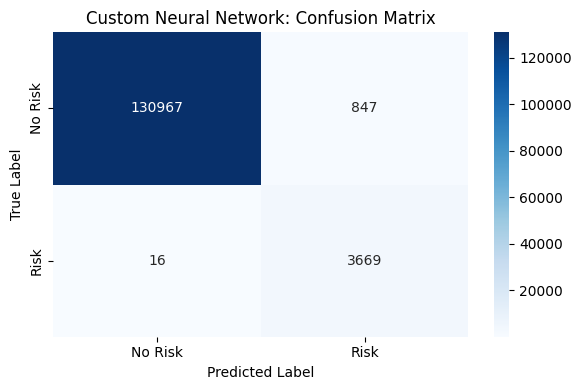

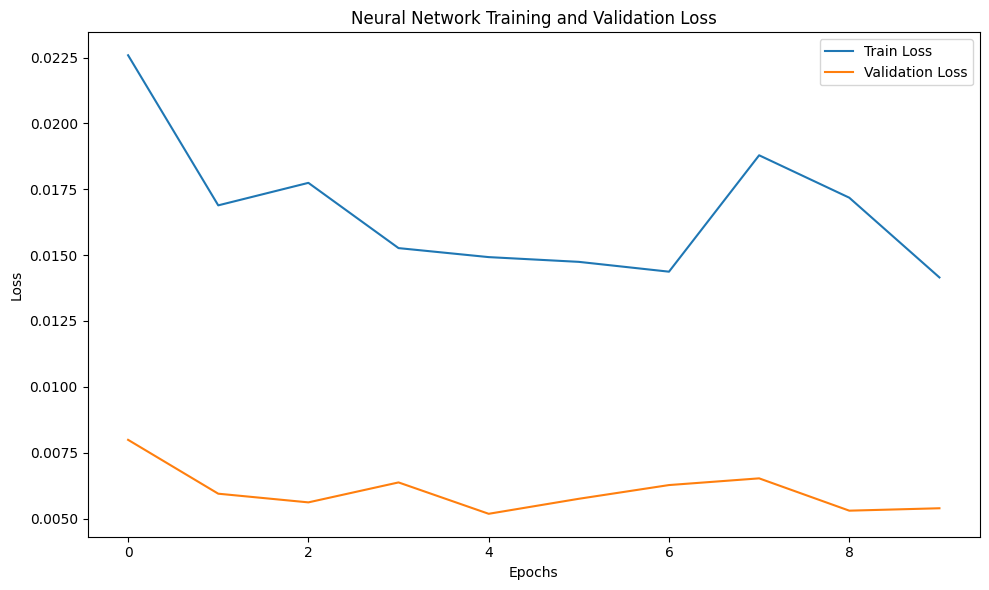

In [42]:
# Confusion Matrix for Neural Network
conf_matrix_nn = confusion_matrix(y_test, dense_y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix_nn, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Risk', 'Risk'], yticklabels=['No Risk', 'Risk'])
plt.title('Custom Neural Network: Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

# Plot Training and Validation Loss for Neural Network
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Neural Network Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

# 9.Model Comparison

In [43]:
#Compile Evaluation Metrics
metrics_df = pd.DataFrame({
    'Model': ['Random Forest', 'XGBoost', 'Custom CNN'],
    'Accuracy': [rf_accuracy, xgb_accuracy, dense_accuracy],
    'F1 Score': [rf_f1, xgb_f1, dense_f1],
    'Precision': [rf_precision, xgb_precision, dense_precision],
    'Recall': [rf_recall, xgb_recall, dense_recall],
    'ROC-AUC': [rf_roc_auc, xgb_roc_auc, dense_roc_auc]
})

print(metrics_df)

           Model  Accuracy  F1 Score  Precision    Recall   ROC-AUC
0  Random Forest  0.995100  0.916394   0.854827  0.987517  0.999187
1        XGBoost  0.997070  0.947285   0.927457  0.967978  0.999749
2     Custom CNN  0.993631  0.894769   0.812445  0.995658  0.999473


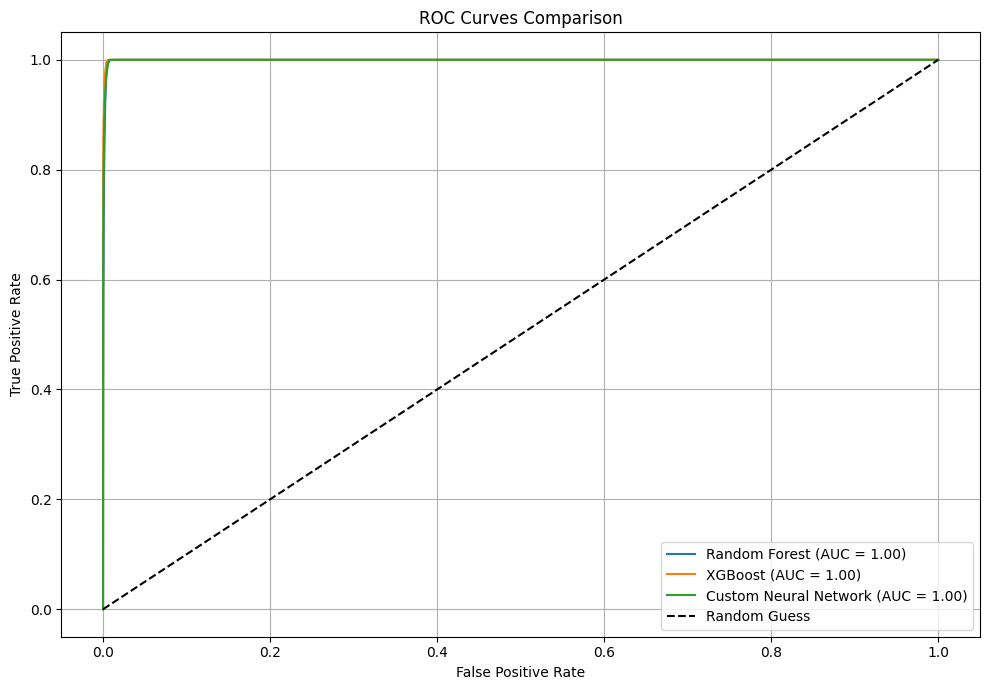

In [44]:
# ROC Curves
plt.figure(figsize=(10, 7))

# Random Forest ROC
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_y_prob)
plt.plot(rf_fpr, rf_tpr, label=f'Random Forest (AUC = {rf_roc_auc:.2f})')

# XGBoost ROC
xgb_fpr, xgb_tpr, _ = roc_curve(y_test, xgb_y_prob)
plt.plot(xgb_fpr, xgb_tpr, label=f'XGBoost (AUC = {xgb_roc_auc:.2f})')

# Custom Neural Network ROC
dense_fpr, dense_tpr, _ = roc_curve(y_test, dense_y_prob)
plt.plot(dense_fpr, dense_tpr, label=f'Custom Neural Network (AUC = {dense_roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.title('ROC Curves Comparison')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid()
plt.tight_layout()
plt.show()

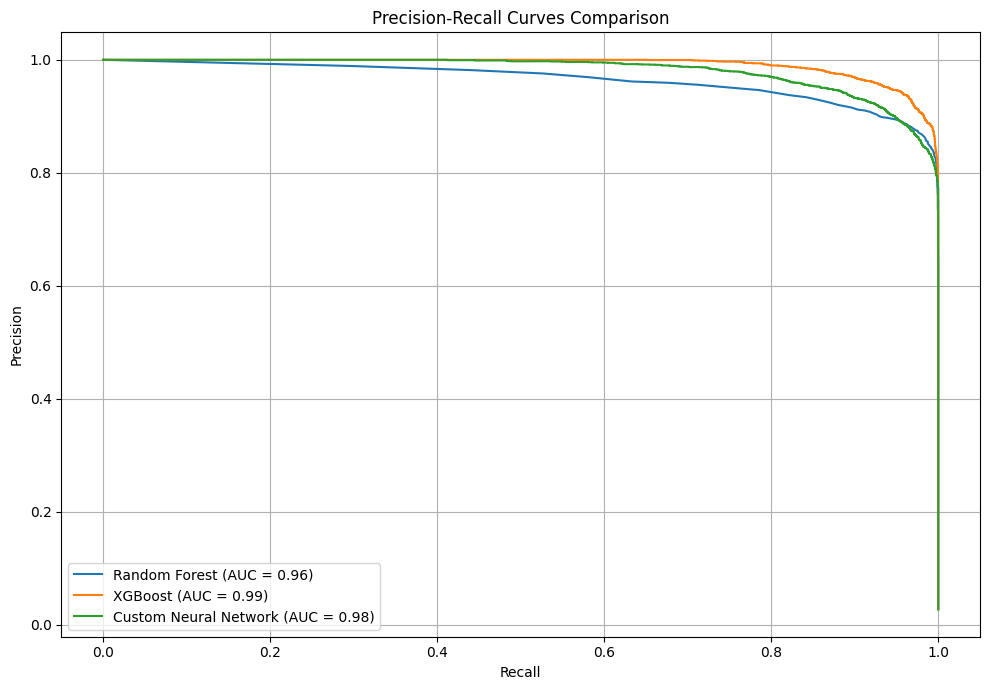

In [45]:
# Precision-Recall Curves
plt.figure(figsize=(10, 7))

# Random Forest PR Curve
rf_precision_vals, rf_recall_vals, _ = precision_recall_curve(y_test, rf_y_prob)
rf_auc_pr = auc(rf_recall_vals, rf_precision_vals)
plt.plot(rf_recall_vals, rf_precision_vals, label=f'Random Forest (AUC = {rf_auc_pr:.2f})')

# XGBoost PR Curve
xgb_precision_vals, xgb_recall_vals, _ = precision_recall_curve(y_test, xgb_y_prob)
xgb_auc_pr = auc(xgb_recall_vals, xgb_precision_vals)
plt.plot(xgb_recall_vals, xgb_precision_vals, label=f'XGBoost (AUC = {xgb_auc_pr:.2f})')

# Custom Neural Network PR Curve
dense_precision_vals, dense_recall_vals, _ = precision_recall_curve(y_test, dense_y_prob)
dense_auc_pr = auc(dense_recall_vals, dense_precision_vals)
plt.plot(dense_recall_vals, dense_precision_vals, label=f'Custom Neural Network (AUC = {dense_auc_pr:.2f})')

plt.title('Precision-Recall Curves Comparison')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='lower left')
plt.grid()
plt.tight_layout()
plt.show()

## 9.2 Feature Importance Comparison

In [46]:
# Feature Importance Random Forest
importance_rf = rf_model.feature_importances_
feature_importance_rf = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importance_rf
}).sort_values(by='Importance', ascending=False)

# Print the top 20 features
print("Top 20 Feature Importances (Random Forest):")
print(feature_importance_rf.head(20))

Top 20 Feature Importances (Random Forest):
                  Feature  Importance
5                       q    0.175643
13                    neo    0.173044
11                      H    0.136266
0                       a    0.071103
20                      n    0.060624
22                    per    0.057108
44       orbital_velocity    0.055154
45  adjusted_eccentricity    0.044797
1                       e    0.038570
24                  t_jup    0.034488
8                data_arc    0.028850
7                   per_y    0.022754
9          condition_code    0.020683
23               moid_jup    0.016825
6                      ad    0.011575
14                    pha    0.009122
37         first_obs_year    0.007443
40          last_obs_year    0.006158
16                H_sigma    0.005259
17                  epoch    0.002857


In [47]:
# Feature Importance XGBoost
importance_xgb = xgb_model.feature_importances_
feature_importance_xgb = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importance_xgb
}).sort_values(by='Importance', ascending=False)

# Print the top 20 features
print("Top 20 Feature Importances (XGBoost):")
print(feature_importance_xgb.head(20))

Top 20 Feature Importances (XGBoost):
                      Feature  Importance
5                           q    0.819014
14                        pha    0.089875
13                        neo    0.034764
11                          H    0.008797
9              condition_code    0.007776
43  relative_orbital_distance    0.006554
41             last_obs_month    0.003016
38            first_obs_month    0.001967
7                       per_y    0.001474
2                           i    0.001460
8                    data_arc    0.001426
28                    sigma_i    0.001406
10                 n_obs_used    0.001273
4                           w    0.001270
42               last_obs_day    0.001165
17                      epoch    0.001079
27                    sigma_q    0.001021
45      adjusted_eccentricity    0.000984
33                    sigma_n    0.000896
39              first_obs_day    0.000870


In [48]:
# Generate classification reports for each model
rf_class_report = classification_report(y_test, rf_y_pred, output_dict=True)
xgb_class_report = classification_report(y_test, xgb_y_pred, output_dict=True)
dense_class_report = classification_report(y_test, dense_y_pred, output_dict=True)

# Convert to DataFrames
rf_df_report = pd.DataFrame(rf_class_report).transpose()
xgb_df_report = pd.DataFrame(xgb_class_report).transpose()
dense_df_report = pd.DataFrame(dense_class_report).transpose()

rf_df_report['Model'] = 'Random Forest'
xgb_df_report['Model'] = 'XGBoost'
dense_df_report['Model'] = 'Custom Neural Network'

# Combine all reports
comparison_df = pd.concat([rf_df_report, xgb_df_report, dense_df_report], ignore_index=True)

# Reset index and rename columns
comparison_df.reset_index(inplace=True)
comparison_df.rename(columns={'index': 'Metric/Class'}, inplace=True)

# Display the combined classification report
print("\nClassification Report Comparison:")
display(comparison_df)


Classification Report Comparison:


Metric/Class  precision    recall  f1-score        support  \
0              0   0.999650  0.995312  0.997476  131814.000000   
1              1   0.854827  0.987517  0.916394    3685.000000   
2              2   0.995100  0.995100  0.995100       0.995100   
3              3   0.927238  0.991414  0.956935  135499.000000   
4              4   0.995711  0.995100  0.995271  135499.000000   
5              5   0.999104  0.997883  0.998493  131814.000000   
6              6   0.927457  0.967978  0.947285    3685.000000   
7              7   0.997070  0.997070  0.997070       0.997070   
8              8   0.963280  0.982931  0.972889  135499.000000   
9              9   0.997155  0.997070  0.997101  135499.000000   
10            10   0.999878  0.993574  0.996716  131814.000000   
11            11   0.812445  0.995658  0.894769    3685.000000   
12            12   0.993631  0.993631  0.993631       0.993631   
13            13   0.906161  0.994616  0.945743  135499.000000   
14            14   0.994780  0.993631  0.993944  135499.000000   

                    Model  
0           Random Forest  
1           Random Forest  
2           Random Forest  
3           Random Forest  
4           Random Forest  
5                 XGBoost  
6                 XGBoost  
7                 XGBoost  
8                 XGBoost  
9                 XGBoost  
10  Custom Neural Network  
11  Custom Neural Network  
12  Custom Neural Network  
13  Custom Neural Network  
14  Custom Neural Network

## 9.4 Calibration Curve

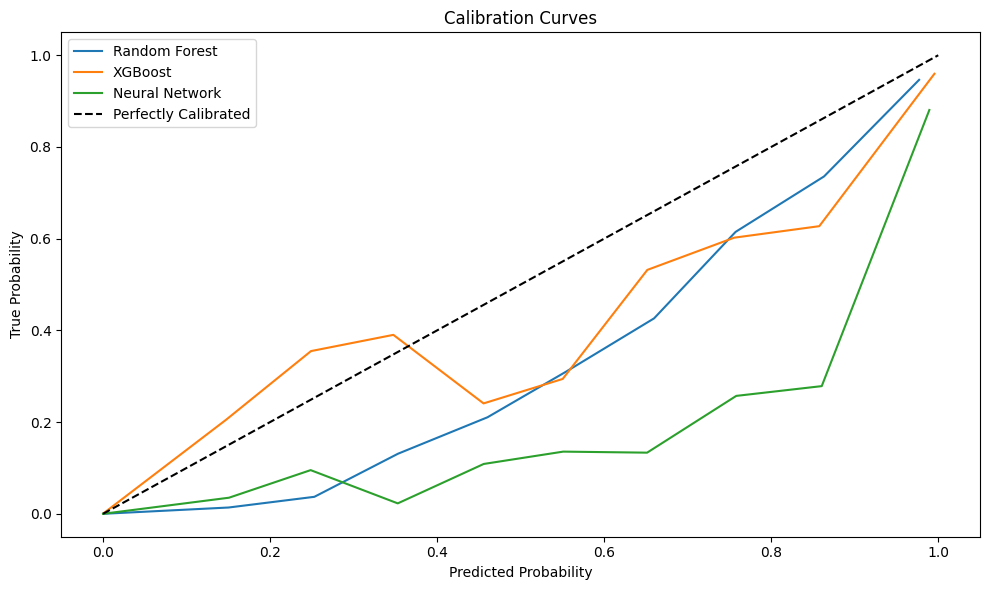

In [49]:
from sklearn.calibration import calibration_curve

plt.figure(figsize=(10, 6))
for model_name, y_prob in zip(['Random Forest', 'XGBoost', 'Neural Network'],
                              [rf_y_prob, xgb_y_prob, dense_y_prob]):
    prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=10)
    plt.plot(prob_pred, prob_true, label=model_name)

plt.plot([0, 1], [0, 1], 'k--', label='Perfectly Calibrated')
plt.title('Calibration Curves')
plt.xlabel('Predicted Probability')
plt.ylabel('True Probability')
plt.legend()
plt.tight_layout()
plt.show()

# 10.Monte Carlo Simulation with Edge Cases

## 10.1 Generate Edge Case Data

In [50]:
def monte_carlo_extended_cases_v2(model, X_test, feature_columns, n_simulations=100, model_type="Random Forest"):
    """
    Monte Carlo Simulation with Extended Edge Cases tailored to orbital dynamics and collision risks.

    Parameters:
    - model: Trained model for predictions
    - X_test: Test data (scaled as NumPy array)
    - feature_columns: List of feature names in the dataset
    - n_simulations: Number of simulations for each edge case
    - model_type: Type of the model (for handling Neural Network predictions)

    Returns:
    - Results: Dictionary of predictions for each edge case
    """
    # Convert X_test to DataFrame
    X_test_df = pd.DataFrame(X_test, columns=feature_columns)

    # Initialize results dictionary
    results = {}

    # Extended Edge Cases aligned with available features
    extended_conditions = {
        "extreme_eccentricity": lambda df: df.assign(e=0.99) if 'e' in df.columns else df,
        "high_velocity": lambda df: df.assign(orbital_velocity=df['orbital_velocity'] * 1.5) if 'orbital_velocity' in df.columns else df,
        "low_velocity": lambda df: df.assign(orbital_velocity=df['orbital_velocity'] * 0.5) if 'orbital_velocity' in df.columns else df,
        "proximity_to_earth": lambda df: df.assign(q=0.01) if 'q' in df.columns else df,
        "distant_orbit": lambda df: df.assign(q=100.0) if 'q' in df.columns else df,
        "low_observation_arc": lambda df: df.assign(arc_length=10) if 'arc_length' in df.columns else df,
        "perturbed_inclination": lambda df: df.assign(i=df['i'] + np.random.normal(0, 5)) if 'i' in df.columns else df,
        "aligned_orbit": lambda df: df.assign(i=0) if 'i' in df.columns else df,
        "large_orbit_uncertainty": lambda df: df.assign(
            sigma_a=df['a'] * 0.2 if 'a' in df.columns else 0,
            sigma_e=df['e'] * 0.2 if 'e' in df.columns else 0,
            sigma_i=df['i'] * 0.2 if 'i' in df.columns else 0
        ) if all(col in df.columns for col in ['a', 'e', 'i']) else df,
    }

    for condition, modifier in extended_conditions.items():
        simulated_data = []
        for _ in range(n_simulations):
            try:
                # Apply the condition modifier
                perturbed_data = modifier(X_test_df).copy()
            except KeyError as e:
                logging.warning(f"KeyError for condition '{condition}': {e}. Skipping.")
                continue
            except Exception as e:
                logging.error(f"Unexpected error for condition '{condition}': {e}. Skipping.")
                continue

            # Ensure perturbed data matches the original feature set
            perturbed_data = perturbed_data[feature_columns]

            # Add random noise for perturbation
            for col in feature_columns:
                if np.issubdtype(perturbed_data[col].dtype, np.number):
                    perturbation = np.random.normal(0, 0.01 * perturbed_data[col].std())
                    perturbed_data[col] += perturbation

            # Predict probabilities
            try:
                if isinstance(model, Sequential):
                    # For Neural Network
                    y_prob = model.predict(perturbed_data).flatten()
                else:
                    # For scikit-learn models
                    y_prob = model.predict_proba(perturbed_data)[:, 1]
                simulated_data.append(y_prob)
            except Exception as e:
                logging.error(f"Error during prediction for condition '{condition}': {e}")
                continue

        # Store results for the edge case
        if simulated_data:  # Avoid storing empty results
            results[condition] = pd.DataFrame(simulated_data).T

    return results

## 10.2 Perform Monte Carlo Simulations

In [51]:
# Sample a subset of the scaled test data
sampled_X_test = X_test_scaled[:1000]  # First 1000 samples for efficiency
feature_columns = X_test.columns

### 10.2.1 Random Forest Simulation

In [52]:
# Monte Carlo Simulation for Random Forest
print("\nRunning Monte Carlo Simulations for Random Forest...")
rf_edge_case_results = monte_carlo_extended_cases_v2(
    model=rf_model,
    X_test=sampled_X_test,
    feature_columns=feature_columns,
    n_simulations=100,
    model_type="Random Forest"
)

# Save Results
rf_save_path = os.path.join(SAVE_DIR, "rf_monte_carlo_results_v2.pkl")
joblib.dump(rf_edge_case_results, rf_save_path)
print(f"Random Forest Monte Carlo results saved at: {rf_save_path}")

logging.info(f"Random Forest Monte Carlo results saved at: {rf_save_path}")


Running Monte Carlo Simulations for Random Forest...
Random Forest Monte Carlo results saved at: /content/drive/My Drive/Predictive_Modeling_for_Asteroid_Collision_Risk_Using_Machine_Learning_and_Orbital_Dynamics/rf_monte_carlo_results_v2.pkl


### 10.2.2 XGBoost Simulation

In [53]:
#Monte Carlo Simulation for XGBoost
print("\nRunning Monte Carlo Simulations for XGBoost...")
xgb_edge_case_results = monte_carlo_extended_cases_v2(
    model=xgb_model,
    X_test=sampled_X_test,
    feature_columns=feature_columns,
    n_simulations=100,
    model_type="XGBoost"
)

# Save Results
xgb_save_path = os.path.join(SAVE_DIR, "xgb_monte_carlo_results_v2.pkl")
joblib.dump(xgb_edge_case_results, xgb_save_path)
print(f"XGBoost Monte Carlo results saved at: {xgb_save_path}")

logging.info(f"XGBoost Monte Carlo results saved at: {xgb_save_path}")


Running Monte Carlo Simulations for XGBoost...
XGBoost Monte Carlo results saved at: /content/drive/My Drive/Predictive_Modeling_for_Asteroid_Collision_Risk_Using_Machine_Learning_and_Orbital_Dynamics/xgb_monte_carlo_results_v2.pkl


###10.2.3 Dense Neural Network Simulation

In [ ]:
print("\nRunning Monte Carlo Simulations for Neural Network...")
print("\nRunning Monte Carlo Simulations for Neural Network...")
nn_edge_case_results = monte_carlo_extended_cases_v2(
    model=dense_model,
    X_test=sampled_X_test,
    feature_columns=feature_columns,
    n_simulations=100,
    model_type="Neural Network"
)

# Save Results
nn_save_path = os.path.join(SAVE_DIR, "nn_monte_carlo_results_v2.pkl")
joblib.dump(nn_edge_case_results, nn_save_path)
print(f"Neural Network Monte Carlo results saved at: {nn_save_path}")

logging.info(f"Neural Network Monte Carlo results saved at: {nn_save_path}")


Running Monte Carlo Simulations for Neural Network...

Running Monte Carlo Simulations for Neural Network...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 945us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
32/

In [ ]:
# Results for Neural Network
for condition, result in nn_edge_case_results.items():
    mean_predictions = result.mean(axis=1)
    std_predictions = result.std(axis=1)
    print(f"\nNeural Network Edge Case: {condition}")
    print(f"Mean Predictions: {mean_predictions.describe()}")
    print(f"Prediction Standard Deviations: {std_predictions.describe()}")

# Histograms for NN Edge Cases
advanced_histograms_for_edge_cases(nn_edge_case_results, "Neural Network")

## 10.3 Analyzing Simulation Results

### 10.3.1  Mean and Standard Deviation of Predictions

In [56]:
def summarize_edge_case_results(edge_case_results, model_name):
    """
    Print mean and standard deviation of predicted probabilities for each edge case.
    """
    print(f"\nAnalysis of {model_name} Edge Cases:")
    for condition, result in edge_case_results.items():
        mean_predictions = result.mean(axis=1)
        std_predictions = result.std(axis=1)
        print(f"\nEdge Case: {condition}")
        print(f"Mean Predictions: {mean_predictions.describe()}")
        print(f"Prediction Standard Deviations: {std_predictions.describe()}")

# Summarize Results
summarize_edge_case_results(rf_edge_case_results, "Random Forest")
summarize_edge_case_results(xgb_edge_case_results, "XGBoost")
summarize_edge_case_results(nn_edge_case_results, "Neural Network")


Analysis of Random Forest Edge Cases:

Edge Case: extreme_eccentricity
Mean Predictions: count    1000.000000
mean        0.033400
std         0.143627
min         0.000000
25%         0.002700
50%         0.003400
75%         0.007900
max         0.957700
dtype: float64
Prediction Standard Deviations: count    1000.000000
mean        0.008556
std         0.013886
min         0.000000
25%         0.004462
50%         0.005143
75%         0.008444
max         0.166036
dtype: float64

Edge Case: high_velocity
Mean Predictions: count    1000.000000
mean        0.031049
std         0.145942
min         0.000000
25%         0.000300
50%         0.002300
75%         0.005300
max         0.959800
dtype: float64
Prediction Standard Deviations: count    1000.000000
mean        0.006691
std         0.014767
min         0.000000
25%         0.001714
50%         0.004578
75%         0.005404
max         0.169216
dtype: float64

Edge Case: low_velocity
Mean Predictions: count    1000.000000
mean  

### 10.3.2  Histograms for Prediction Distributions

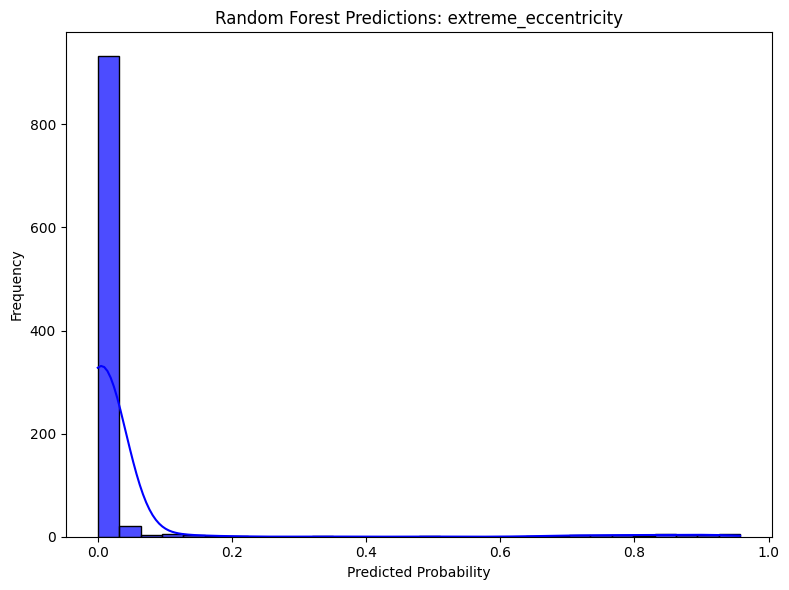

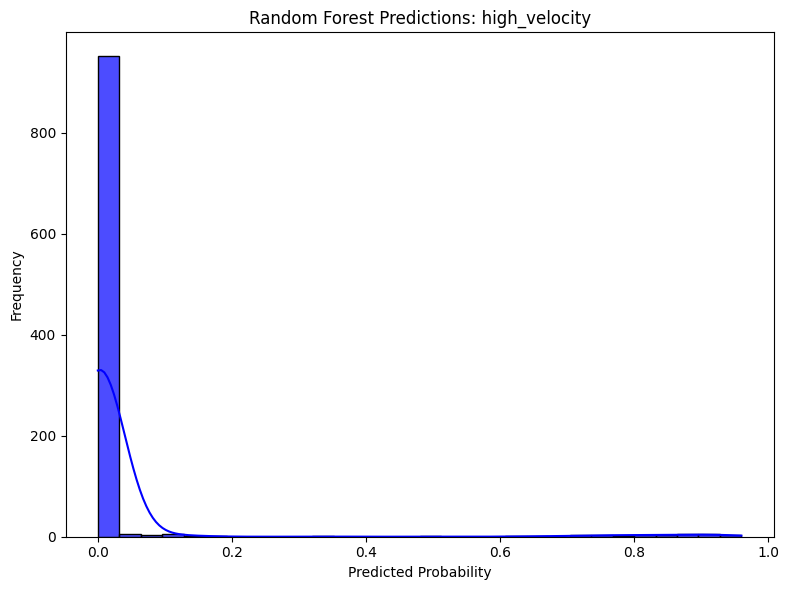

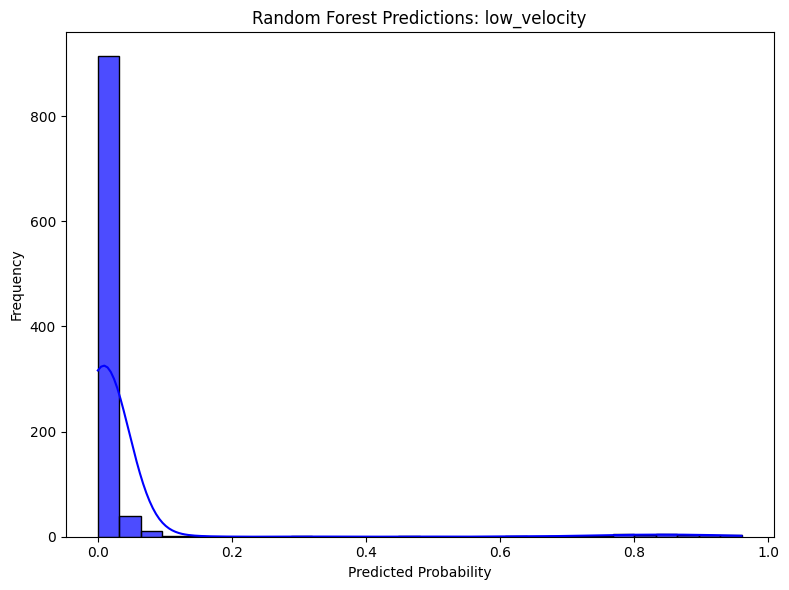

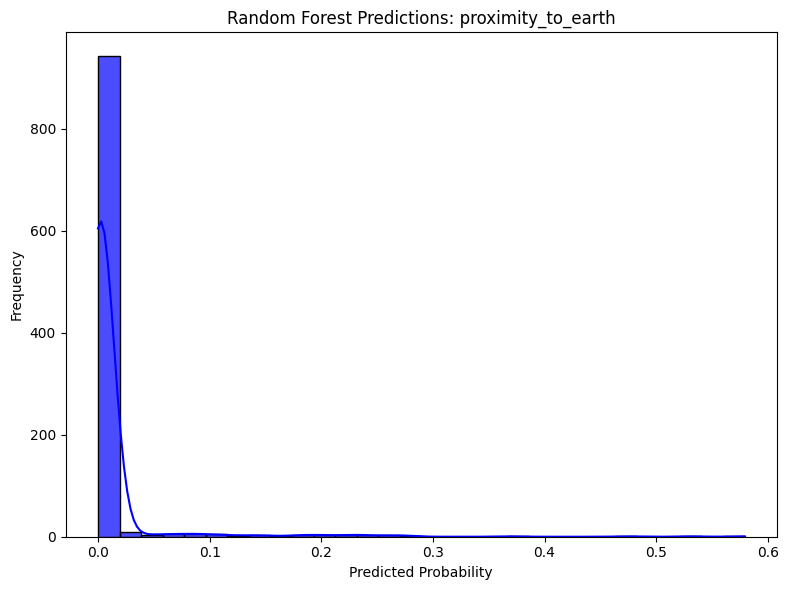

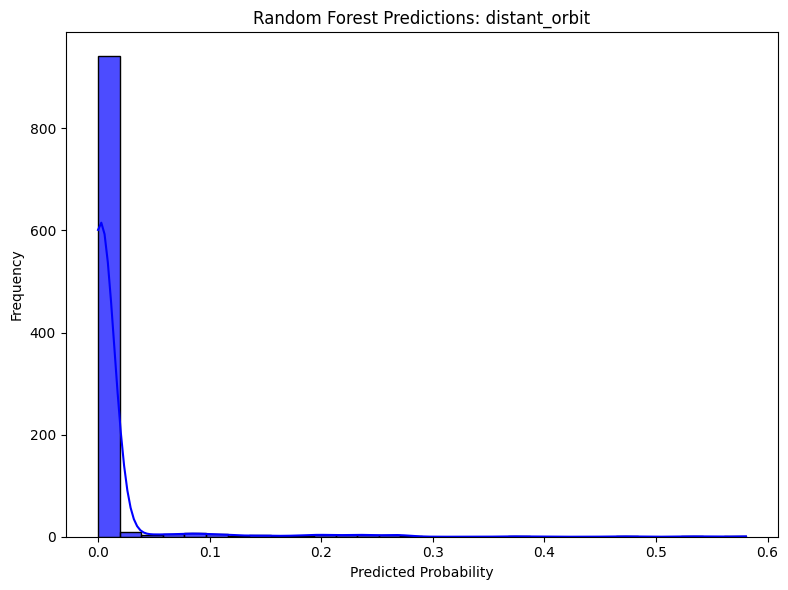

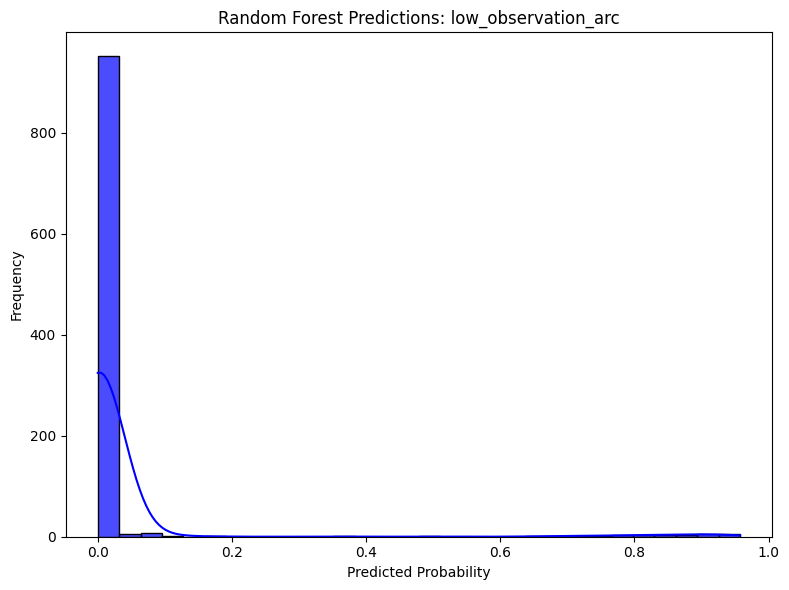

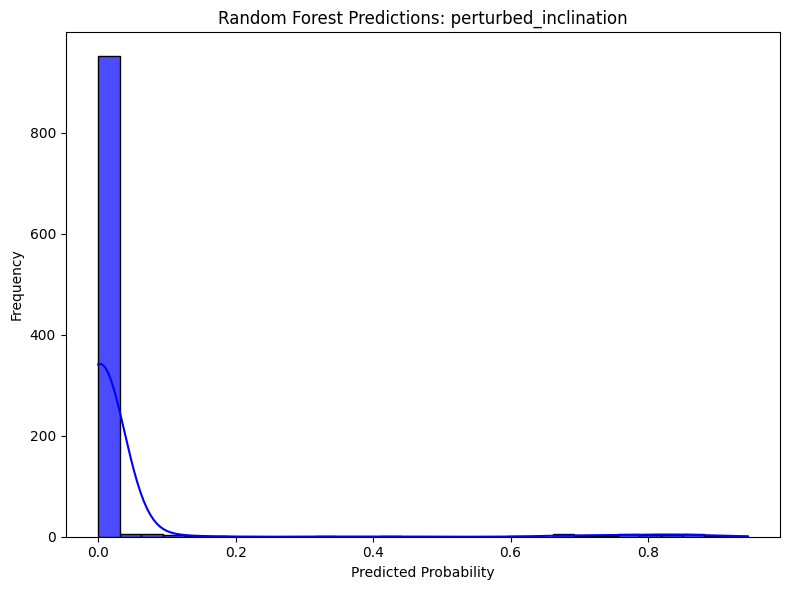

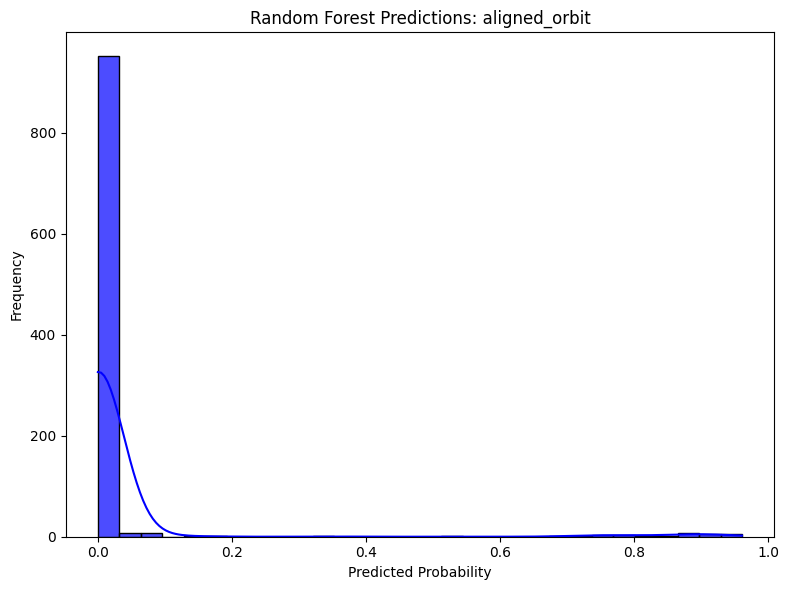

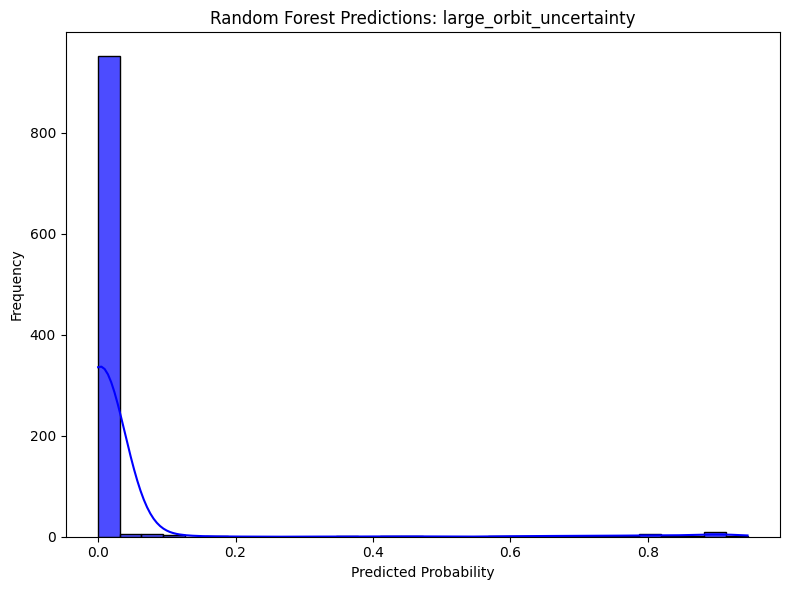

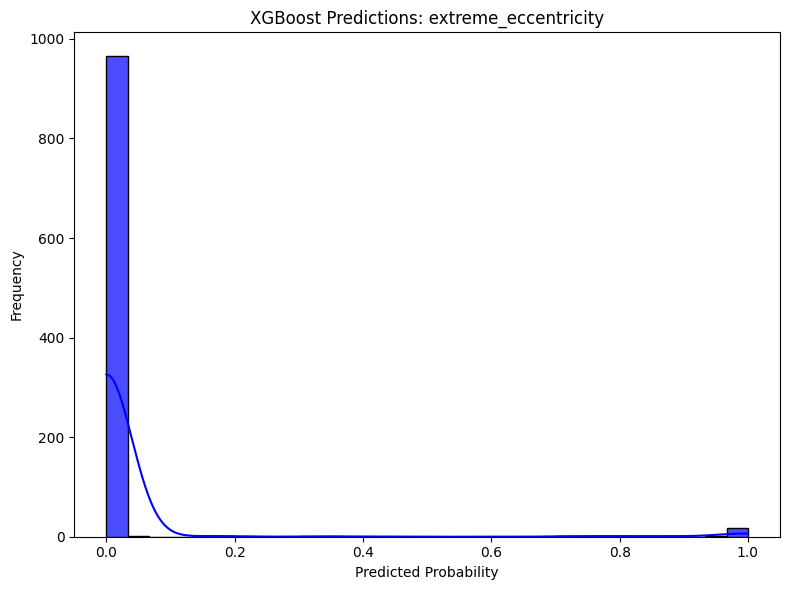

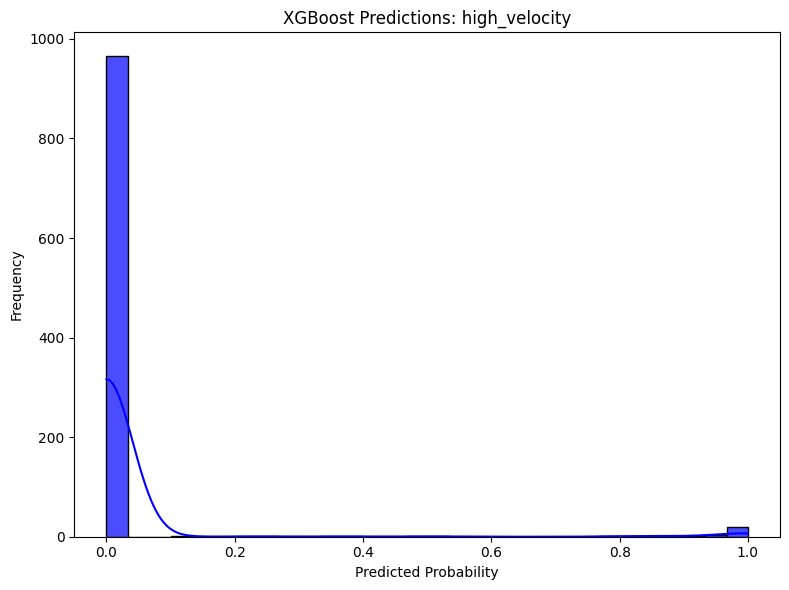

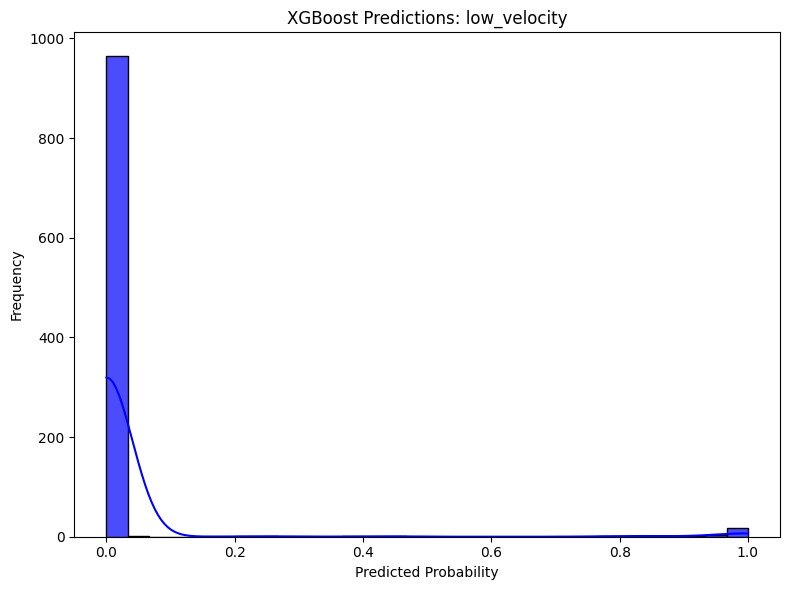

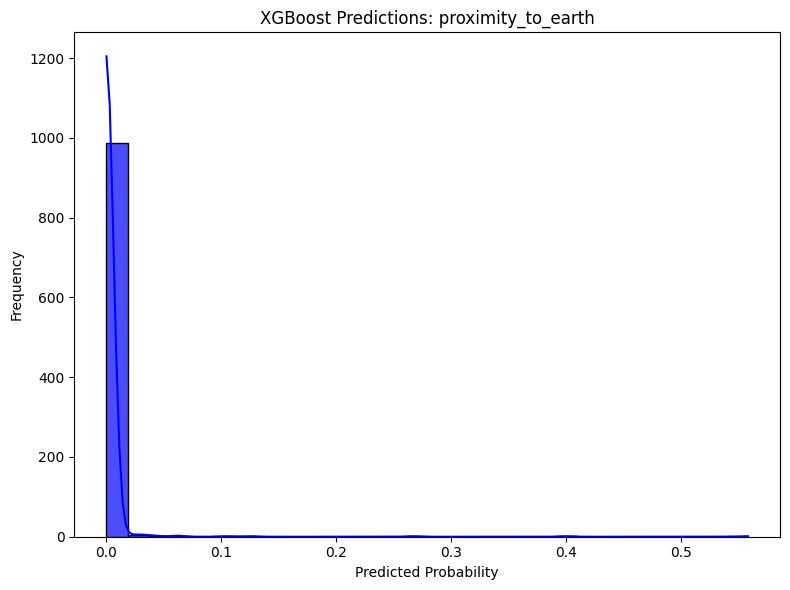

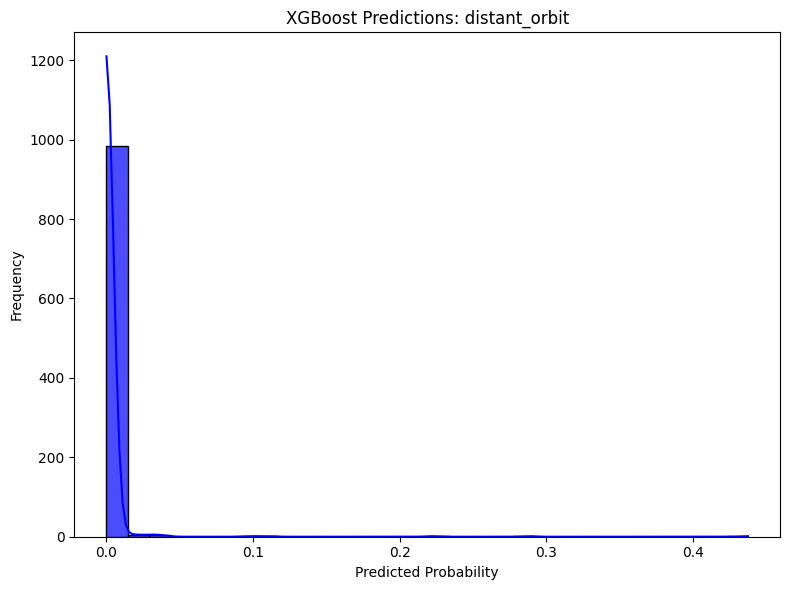

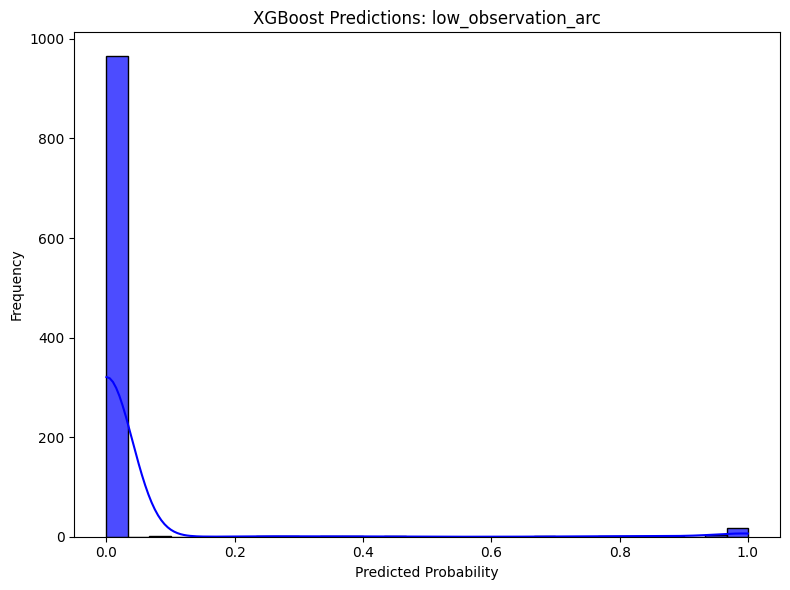

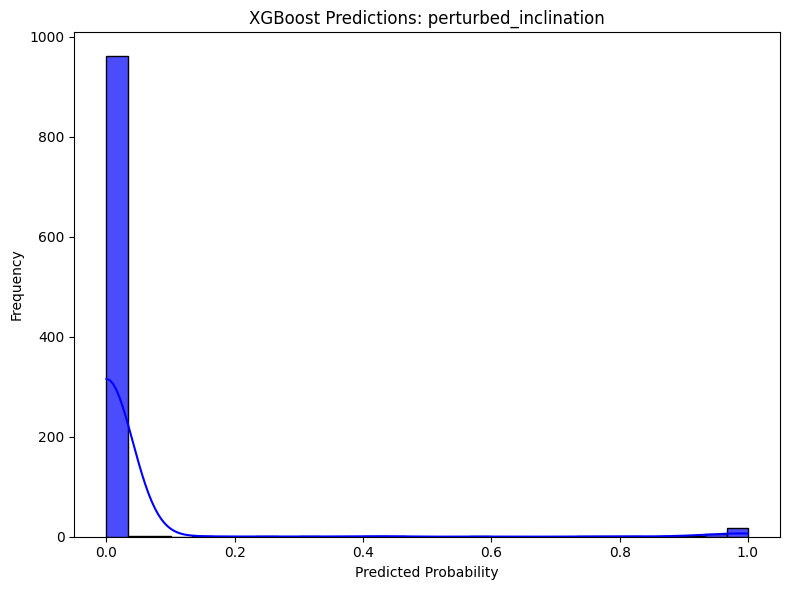

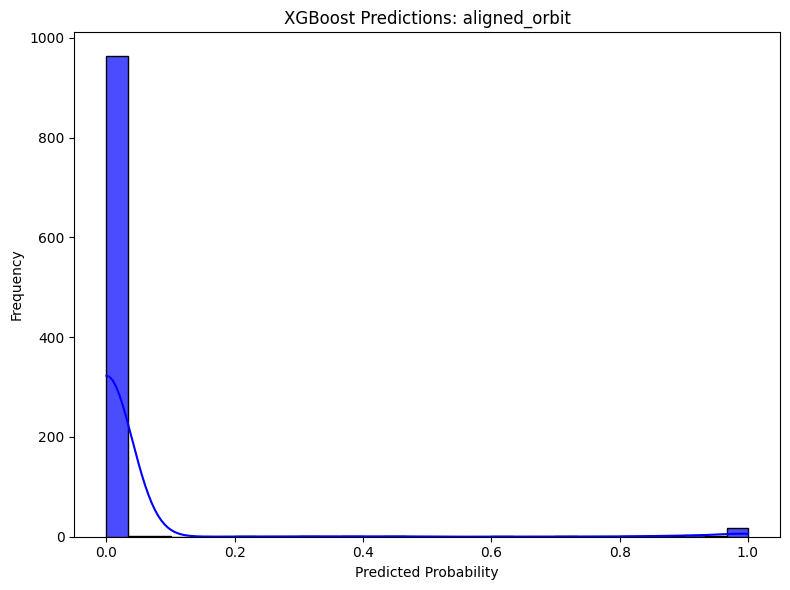

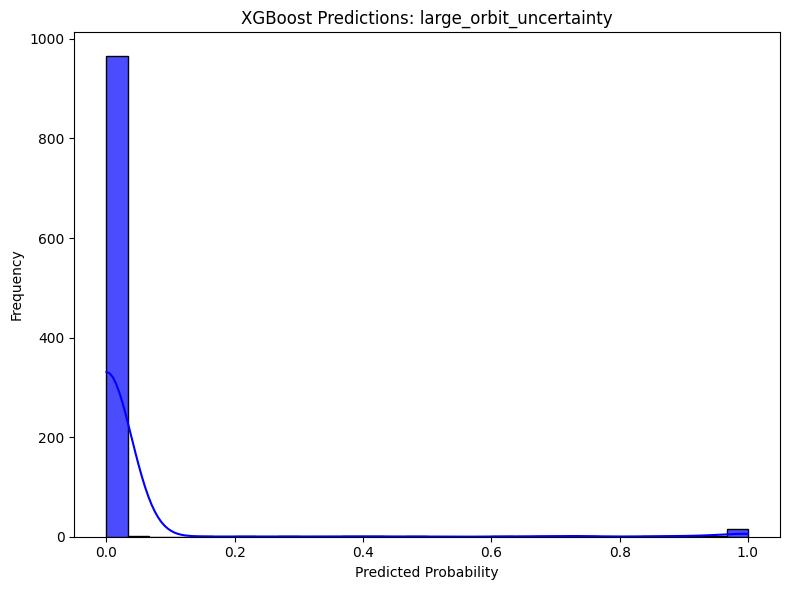

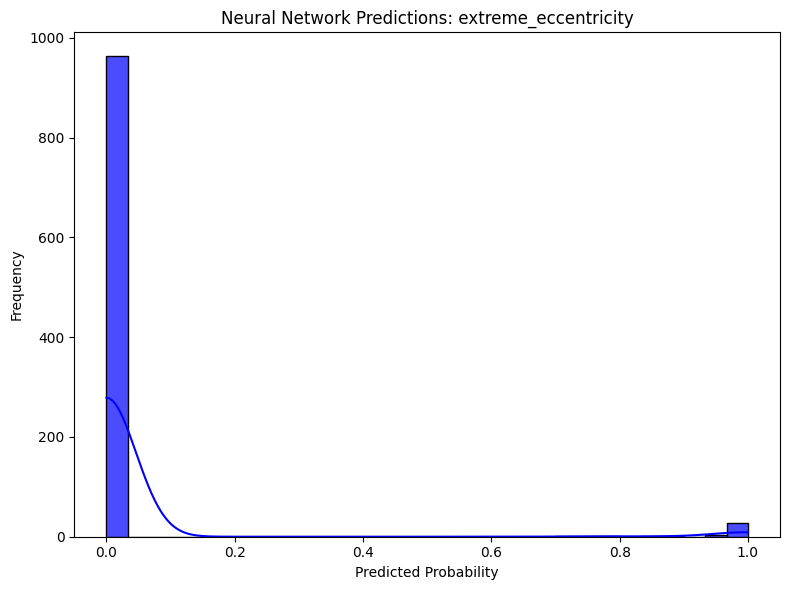

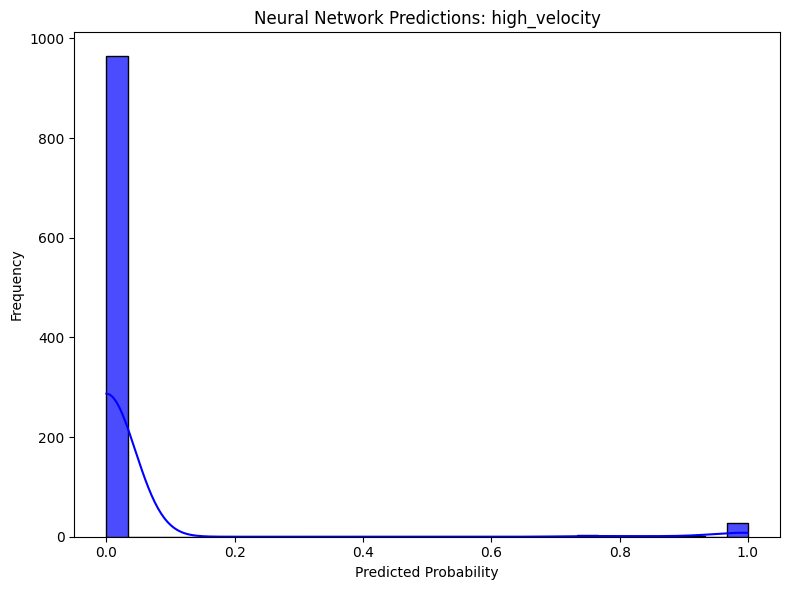

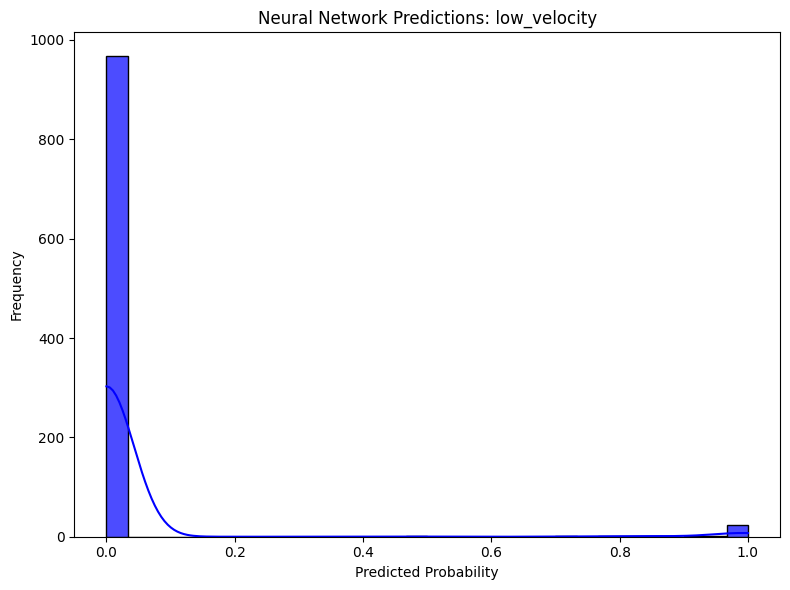

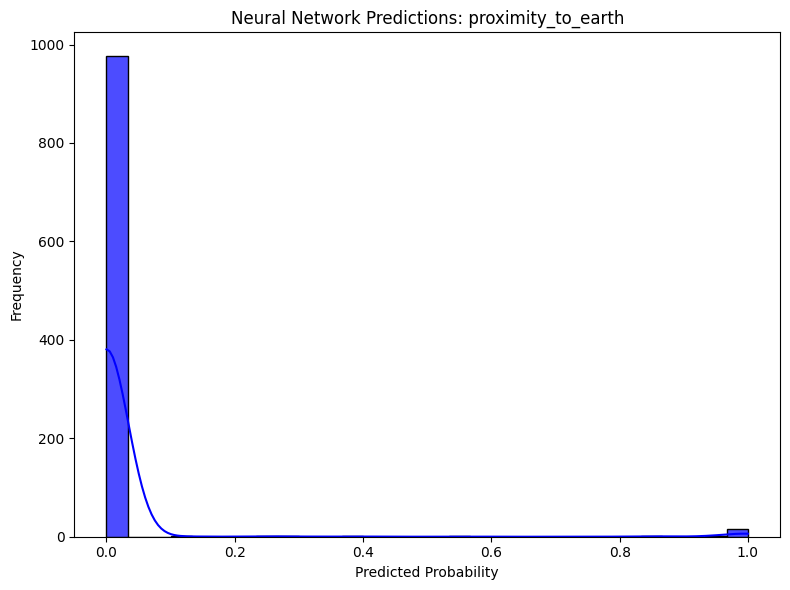

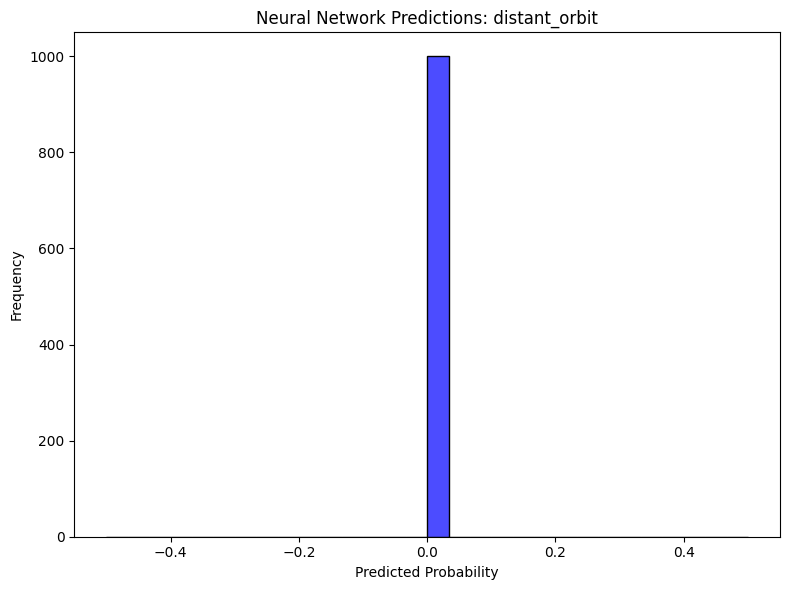

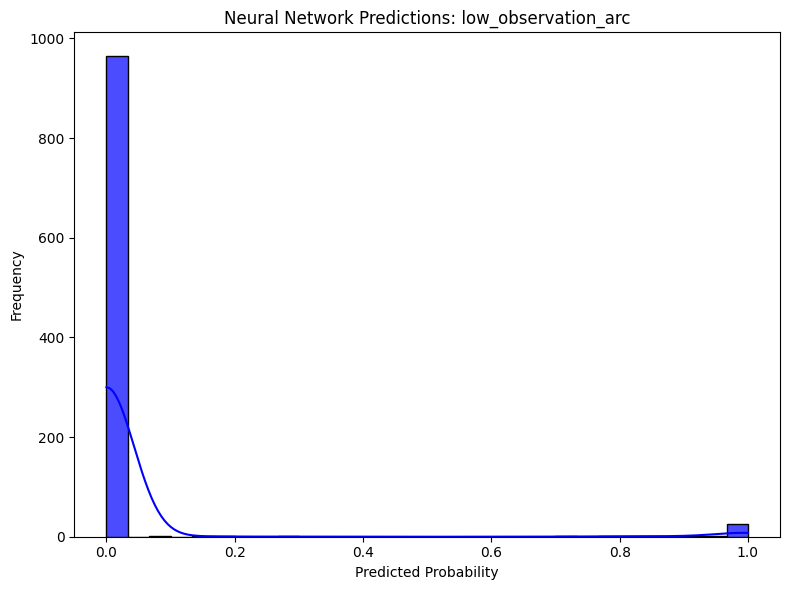

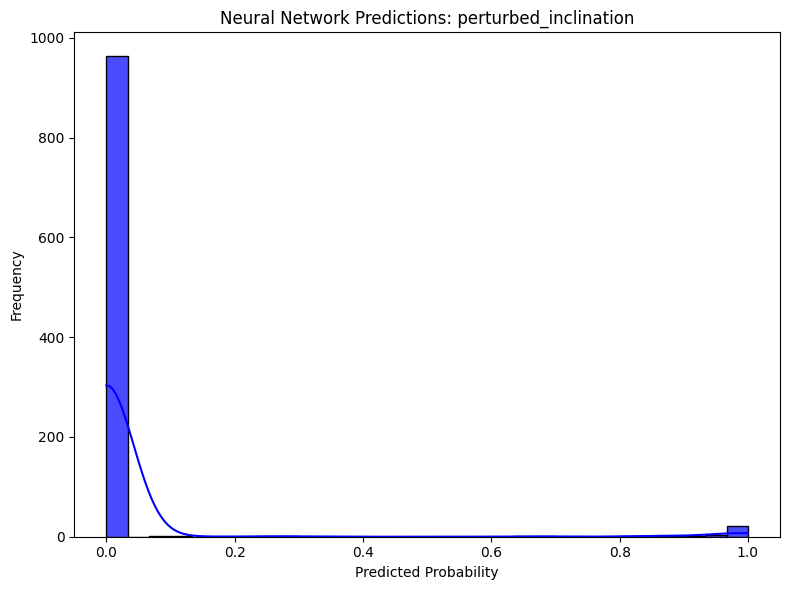

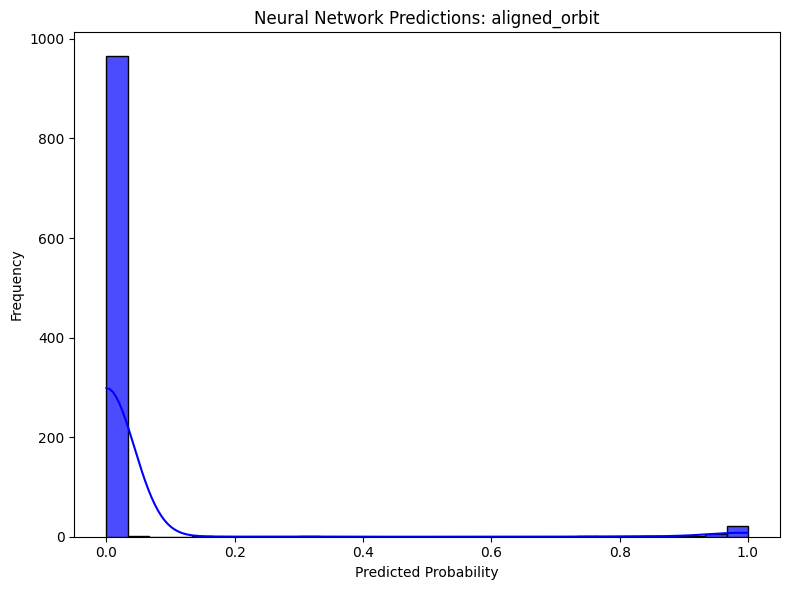

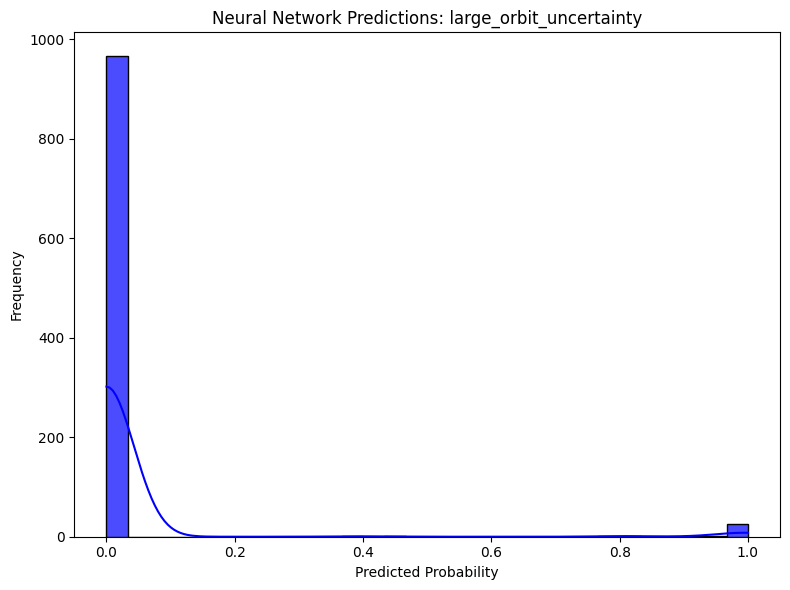

In [57]:
def plot_edge_case_histograms(edge_case_results, model_name):
    """
    Create histograms for each edge case to visualize prediction distributions.
    """
    for condition, result in edge_case_results.items():
        plt.figure(figsize=(8, 6))
        sns.histplot(result.mean(axis=1), kde=True, bins=30, color='blue', alpha=0.7)
        plt.title(f'{model_name} Predictions: {condition}')
        plt.xlabel('Predicted Probability')
        plt.ylabel('Frequency')
        plt.tight_layout()
        plt.show()

# Plot Histograms
plot_edge_case_histograms(rf_edge_case_results, "Random Forest")
plot_edge_case_histograms(xgb_edge_case_results, "XGBoost")
plot_edge_case_histograms(nn_edge_case_results, "Neural Network")

### 10.3.3 Define the Analysis Function

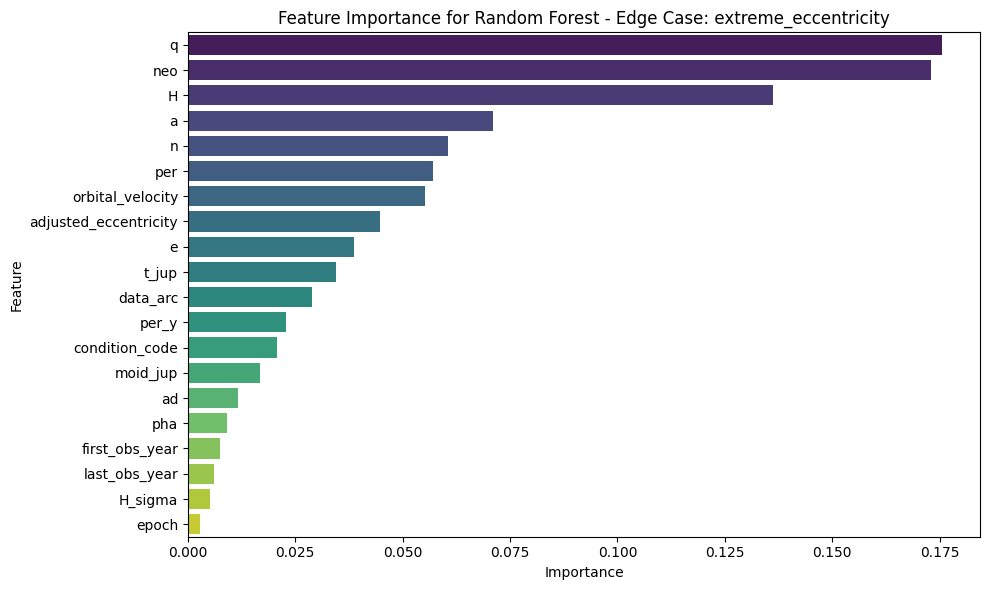

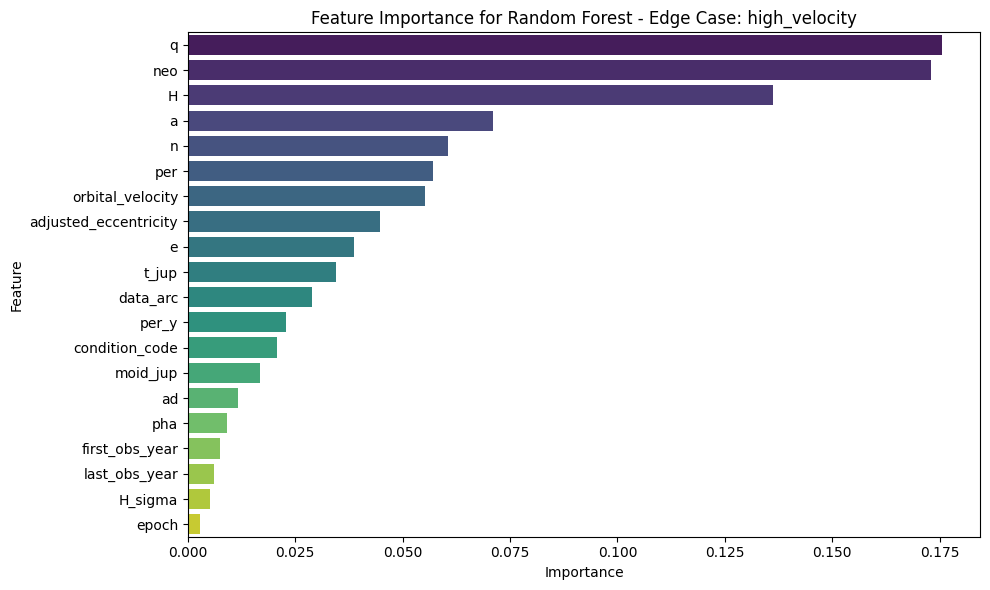

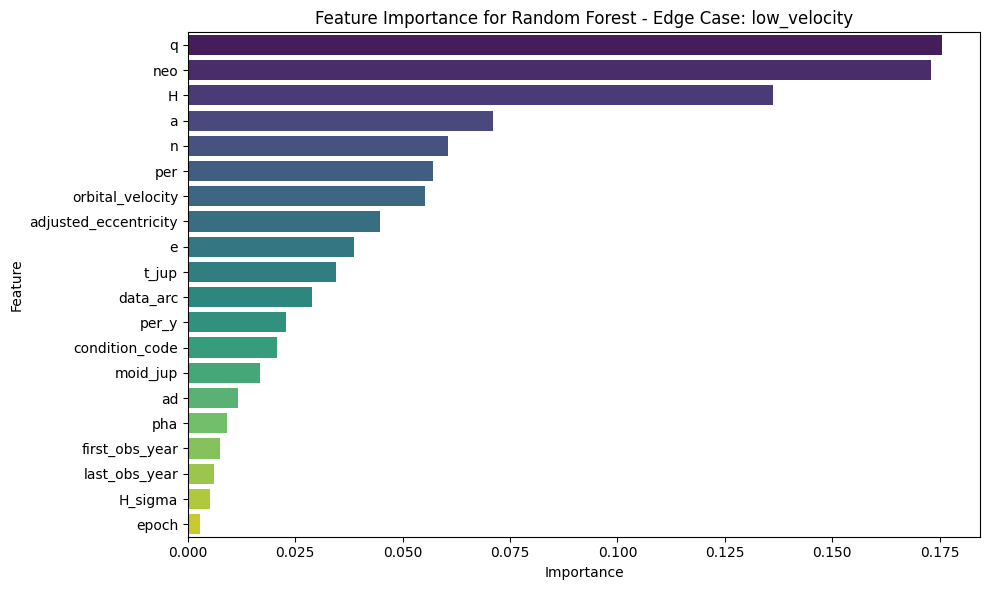

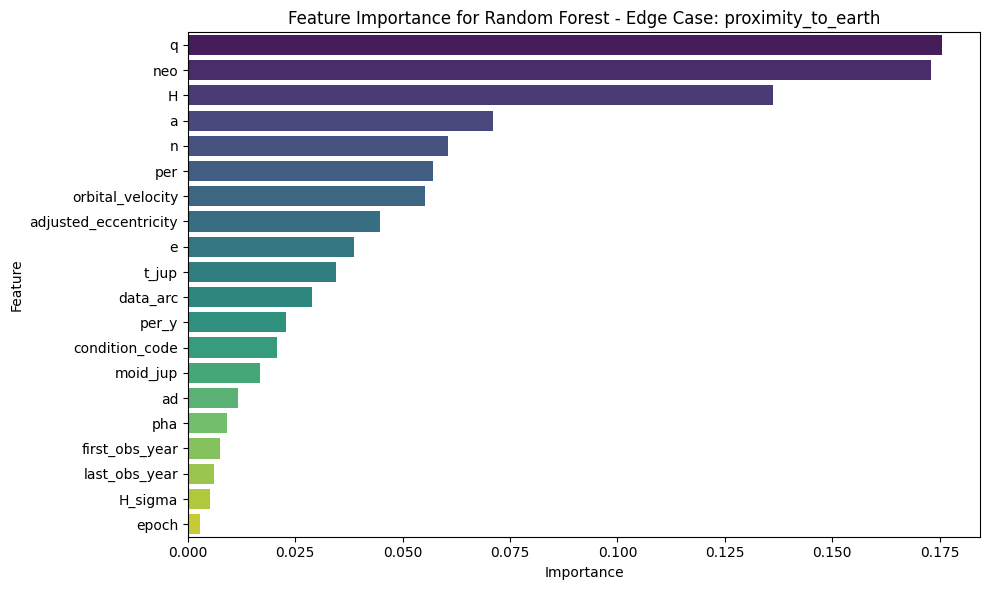

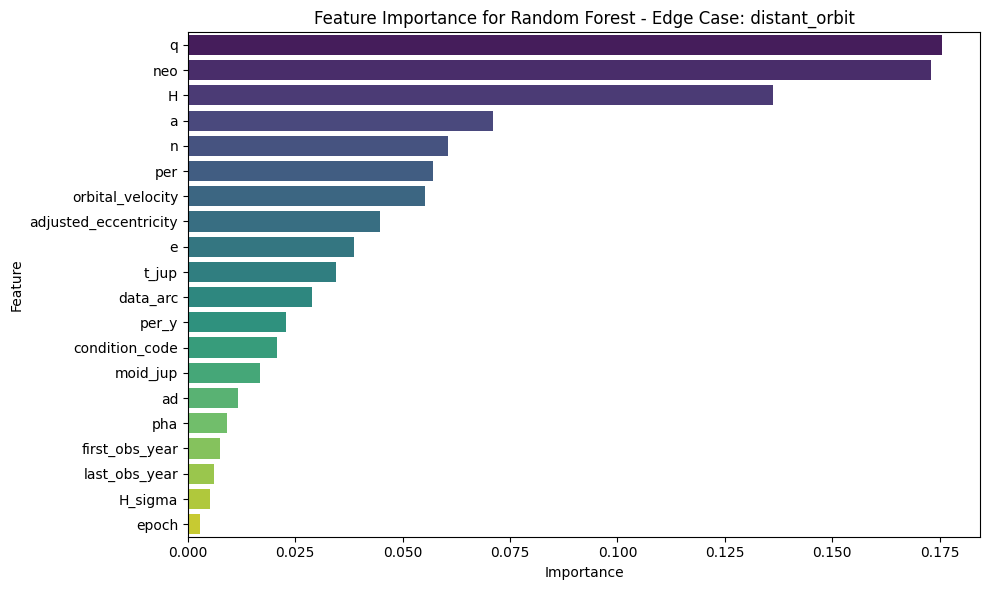

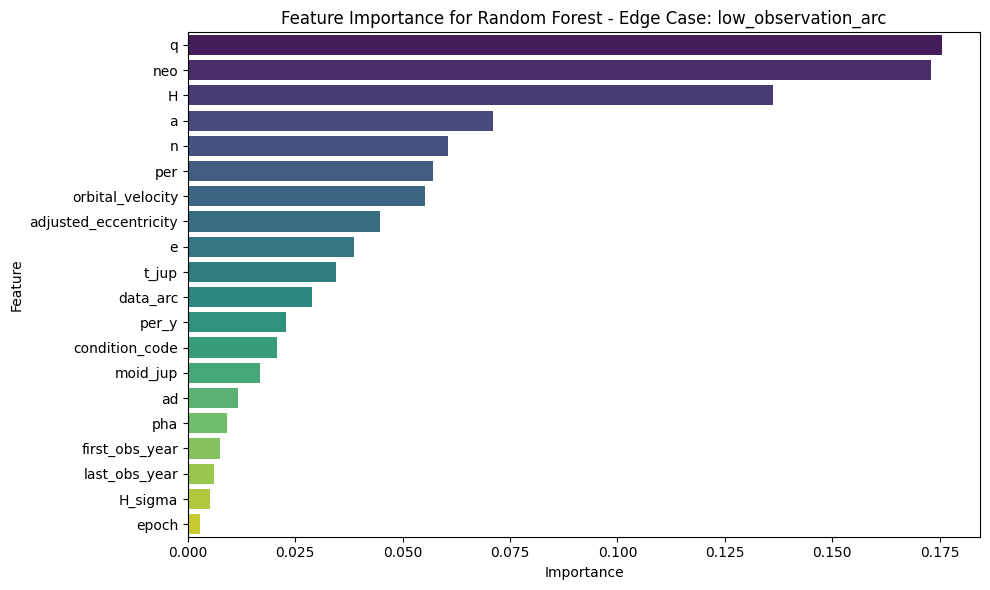

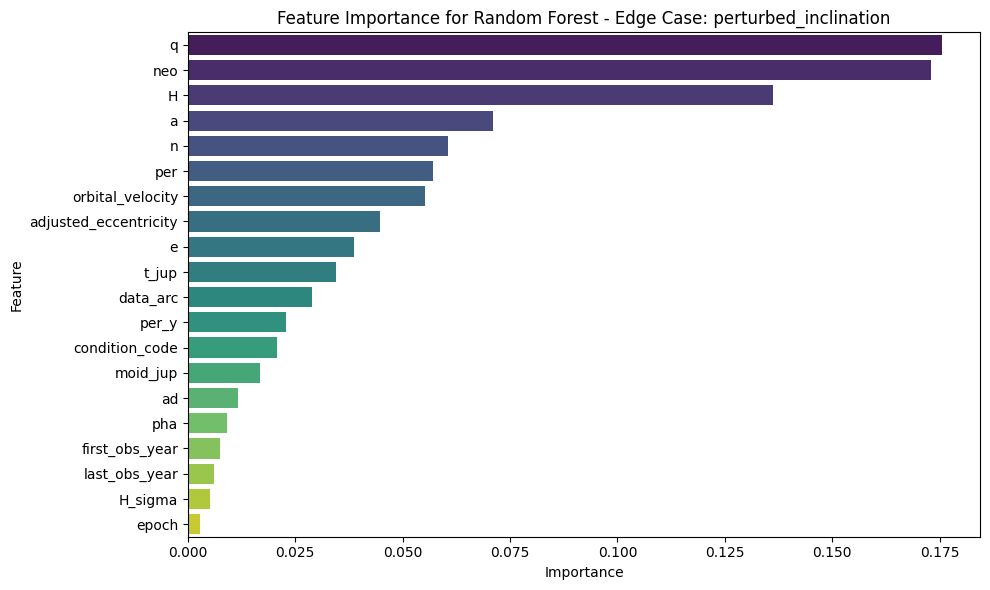

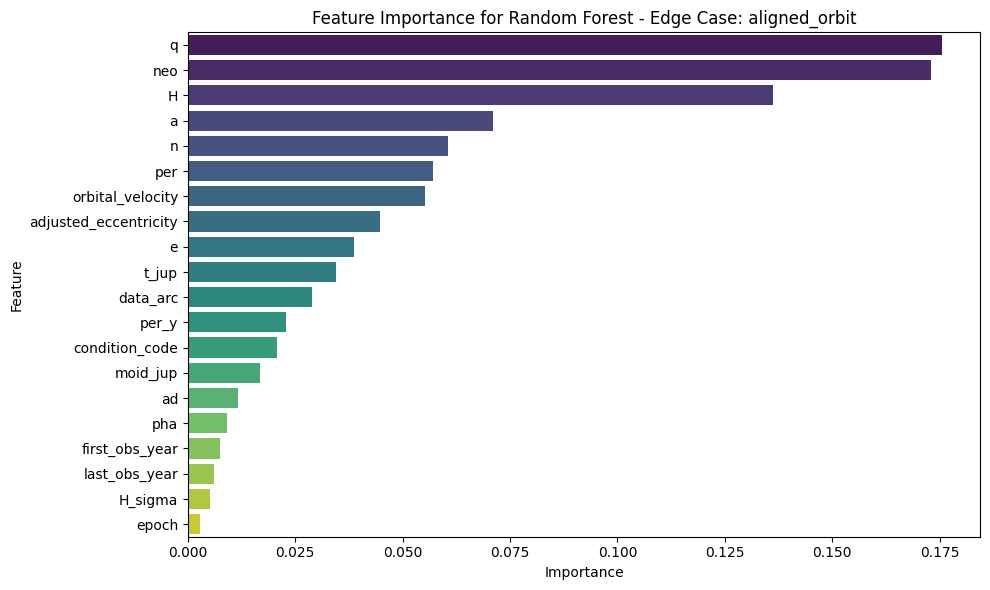

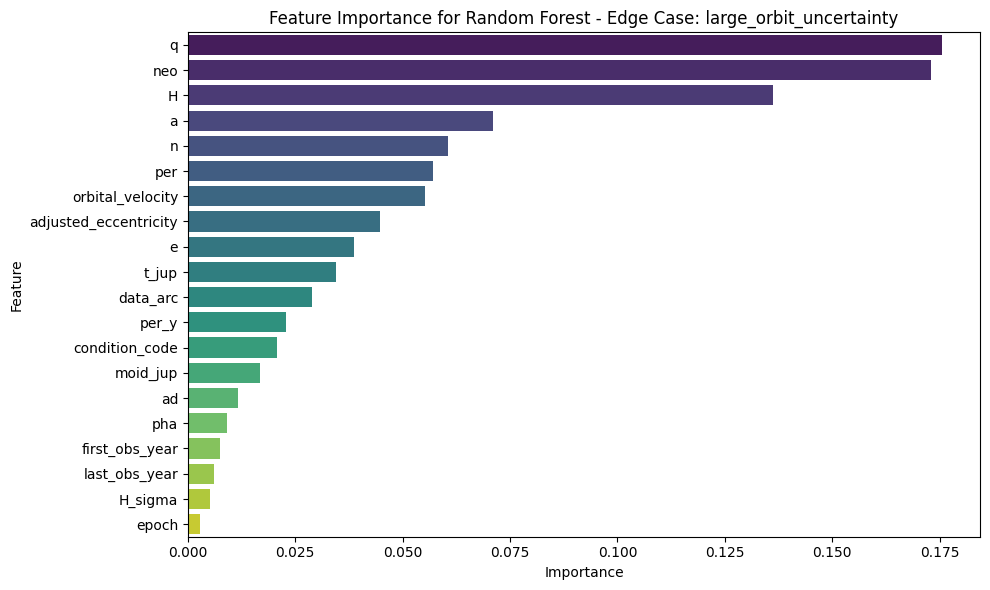

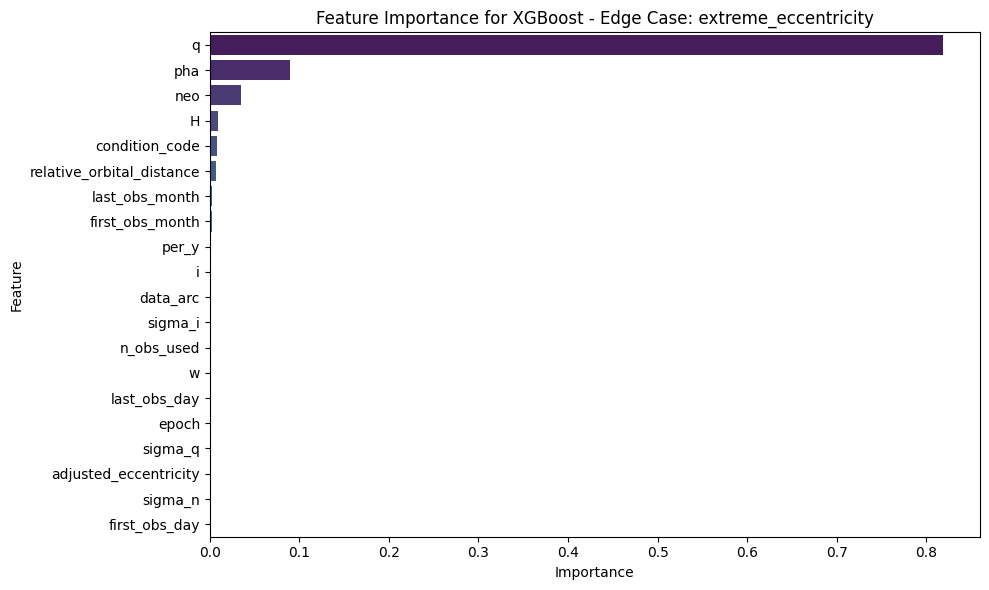

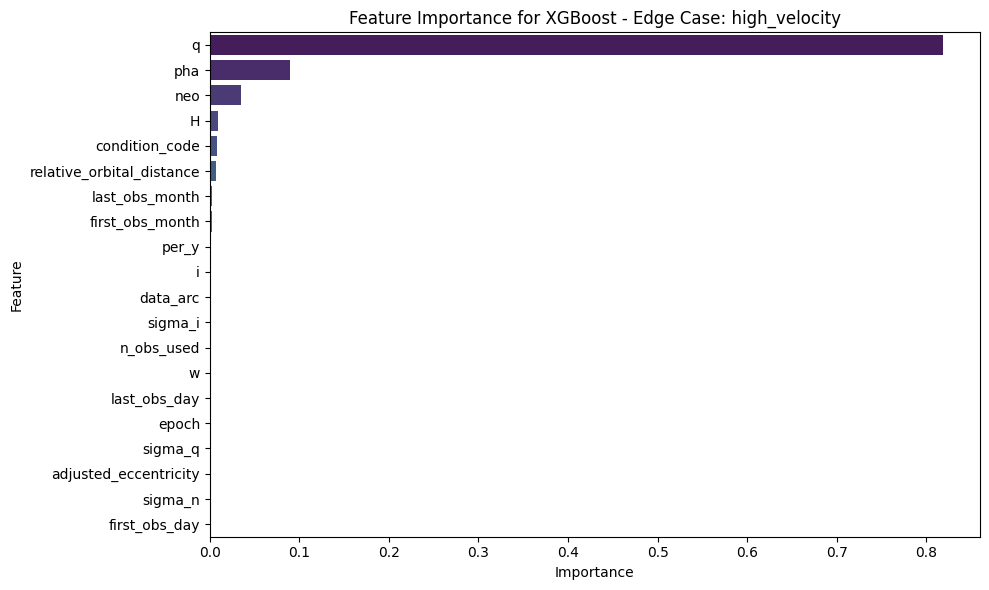

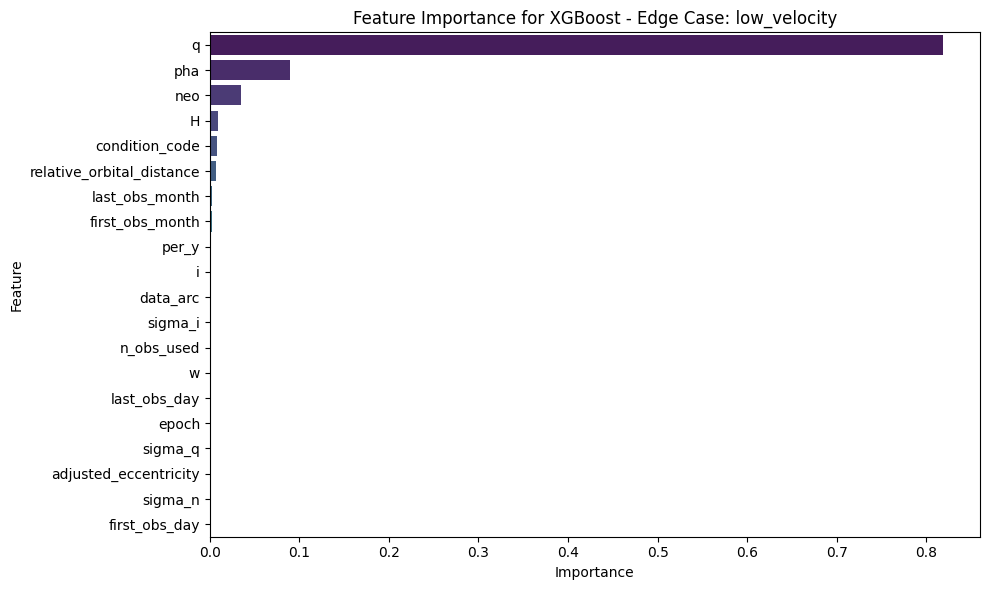

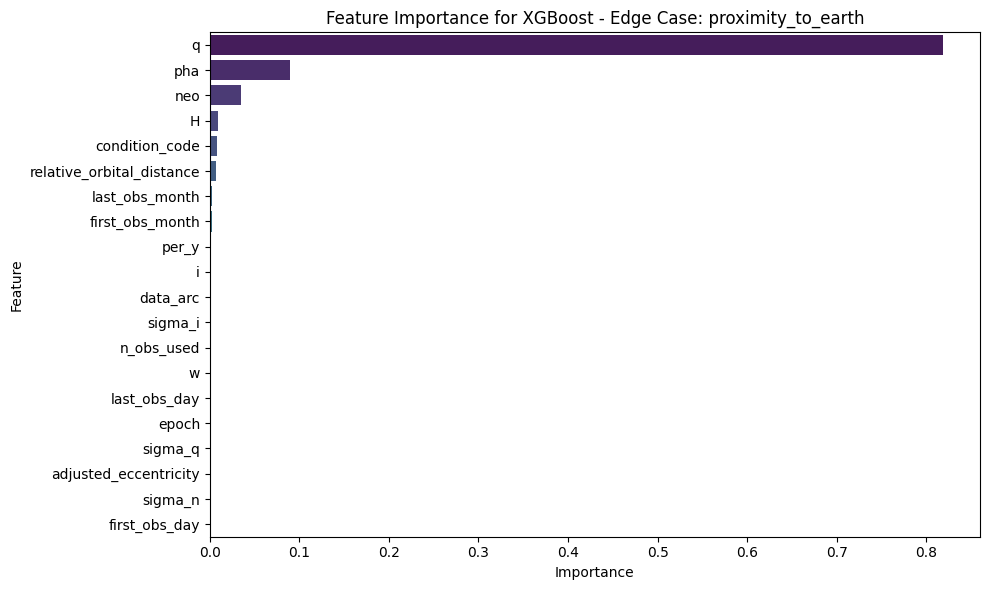

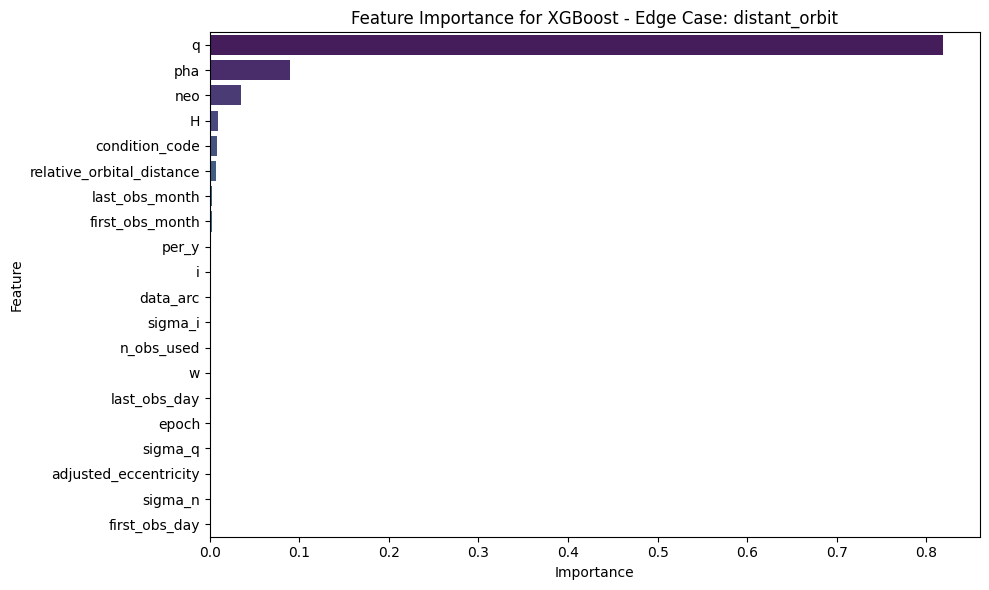

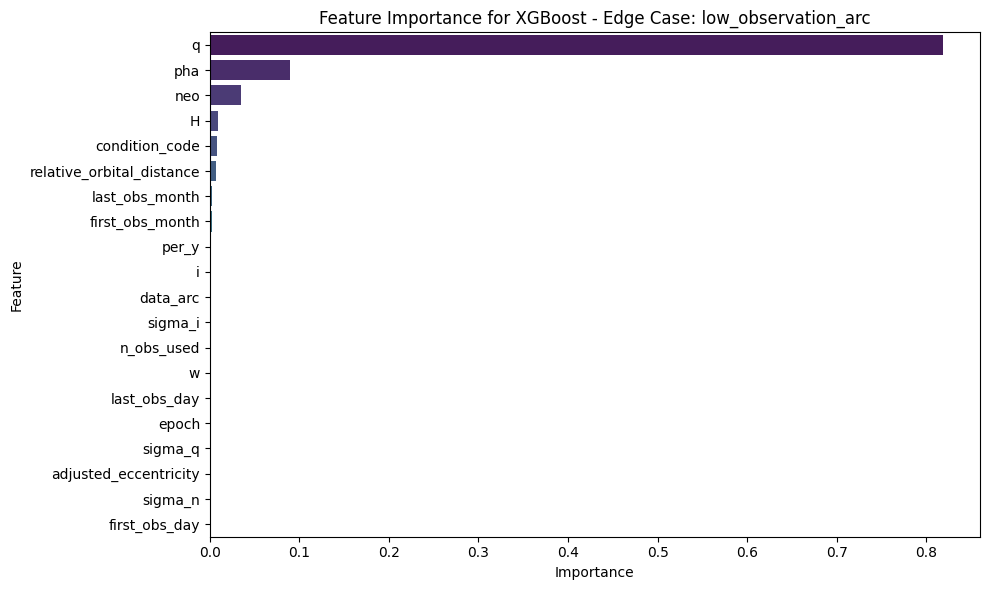

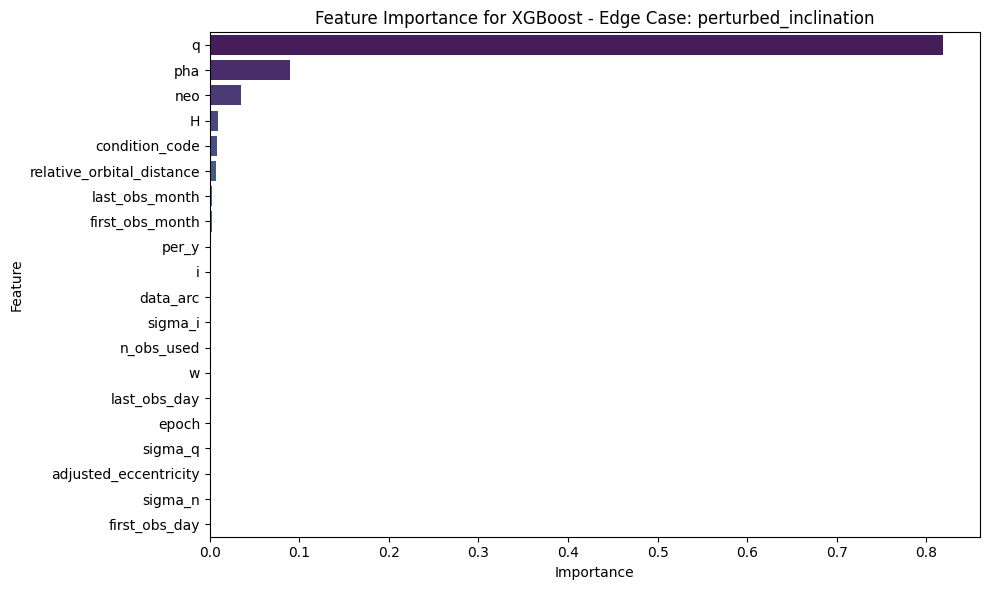

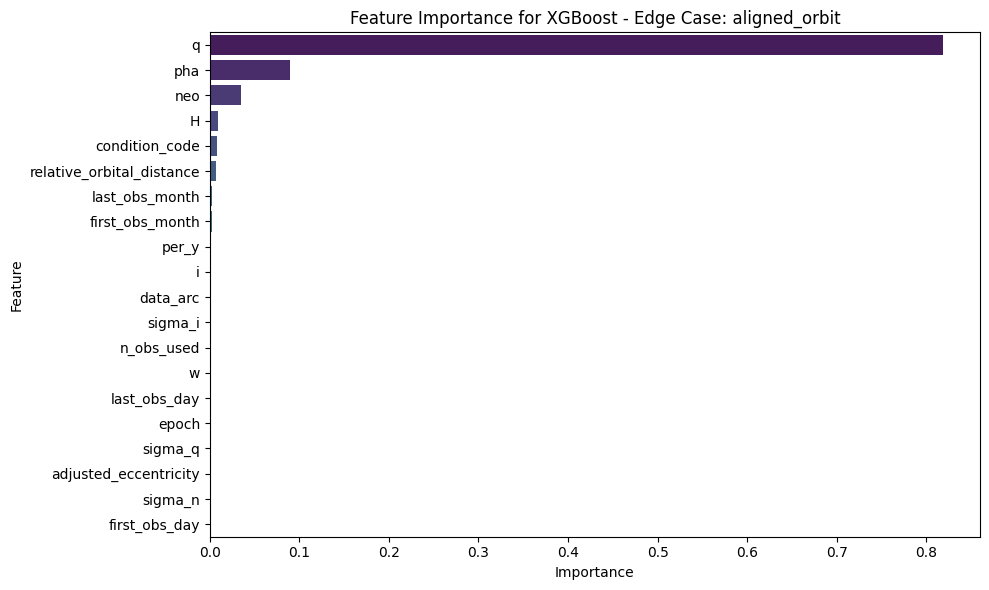

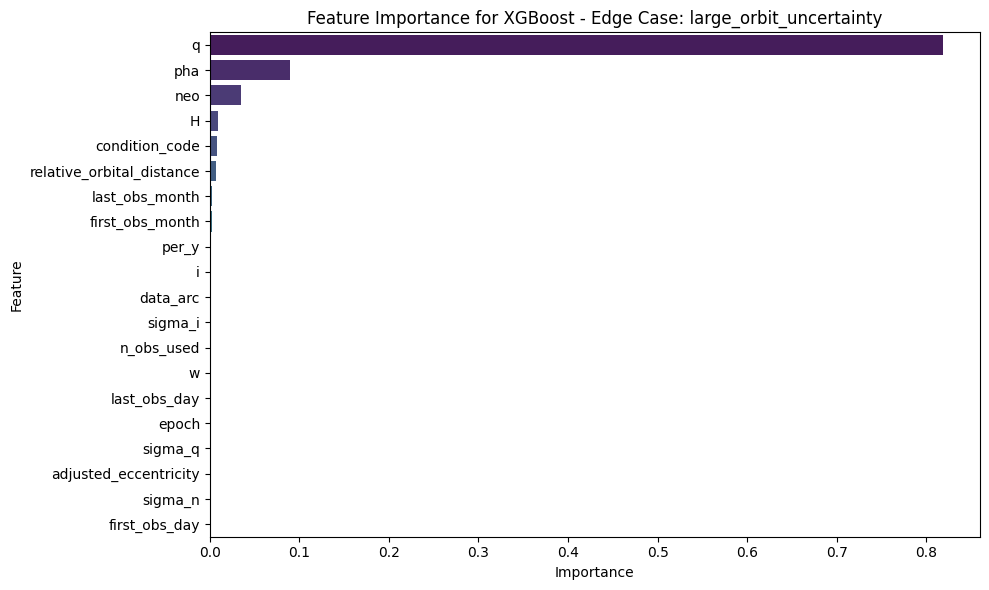

In [59]:
def feature_importance_analysis(edge_case_results, model_type, feature_columns, save_dir):
    """
    Analyze and visualize feature importance for edge cases.
    """
    for condition, result in edge_case_results.items():
        if model_type == "Random Forest":
            importance = rf_model.feature_importances_
        elif model_type == "XGBoost":
            importance = xgb_model.feature_importances_
        else:
            logging.error(f"Unsupported model type: {model_type}")
            continue

        feature_importance_df = pd.DataFrame({
            'Feature': feature_columns,
            'Importance': importance
        }).sort_values(by='Importance', ascending=False)

        # Plot Top 20 Feature Importances
        plt.figure(figsize=(10, 6))
        sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(20), palette='viridis')
        plt.title(f"Feature Importance for {model_type} - Edge Case: {condition}")
        plt.xlabel('Importance')
        plt.ylabel('Feature')
        plt.tight_layout()
        plt.show()

# Run Feature Importance Analysis
feature_importance_analysis(rf_edge_case_results, "Random Forest", feature_columns, SAVE_DIR)
feature_importance_analysis(xgb_edge_case_results, "XGBoost", feature_columns, SAVE_DIR)

logging.info(f"Feature importance plot saved")


# 11.Model Interpretability with LIME

In [60]:
# Define the explainer
lime_explainer = LimeTabularExplainer(
    X_train_resampled_scaled,  # Use scaled training data
    feature_names=feature_names,  # List of feature names
    class_names=['No Risk', 'Risk'],  # Target class labels
    mode='classification'
)

## 11.1 LIME for Random Forest

In [61]:
# Select a sample from the test set
sample_index = 0  # Index of the sample to explain
sample = X_test_scaled[sample_index].reshape(1, -1)

# Predict probabilities using Random Forest
rf_predicted_prob = rf_model.predict_proba(sample)[0]

# Display prediction probabilities
print(f"Random Forest Prediction Probabilities: No Risk={rf_predicted_prob[0]:.2f}, Risk={rf_predicted_prob[1]:.2f}")

# Generate LIME explanation for Random Forest
lime_explanation_rf = lime_explainer.explain_instance(
    sample.flatten(),  # Unscaled input sample
    rf_model.predict_proba,  # Random Forest predict_proba method
    num_features=10  # Number of features to explain
)

# Display the explanation
lime_explanation_rf.show_in_notebook()


Random Forest Prediction Probabilities: No Risk=1.00, Risk=0.00


### 11.1.1 Batch Analysis for Random Forest

In [62]:
# Loop through multiple samples
for i in range(5):  # First 5 test samples
    sample = X_test_scaled[i].reshape(1, -1)
    lime_explanation_rf = lime_explainer.explain_instance(
        sample.flatten(),
        rf_model.predict_proba,
        num_features=10
    )
    lime_explanation_rf.save_to_file(os.path.join(SAVE_DIR, 'rf_explanation.html'))

## 11.2 LIME for XGBoost

In [63]:
# Predict probabilities using XGBoost
xgb_predicted_prob = xgb_model.predict_proba(sample)[0]

# Display prediction probabilities
print(f"XGBoost Prediction Probabilities: No Risk={xgb_predicted_prob[0]:.2f}, Risk={xgb_predicted_prob[1]:.2f}")

#LIME explanation for XGBoost
lime_explanation_xgb = lime_explainer.explain_instance(
    sample.flatten(),  # Unscaled input sample
    xgb_model.predict_proba,  # XGBoost predict_proba method
    num_features=10  # Number of features to explain
)

# Display the explanation
lime_explanation_xgb.show_in_notebook()

XGBoost Prediction Probabilities: No Risk=1.00, Risk=0.00


### 11.2.1 Batch Analysis for XGBoost

In [ ]:
# Loop through multiple samples
for i in range(5):  # First 5 test samples
    sample = X_test_scaled[i].reshape(1, -1)
    lime_explanation_xgb = lime_explainer.explain_instance(
        sample.flatten(),
        xgb_model.predict_proba,
        num_features=10
    )
    lime_explanation_xgb.save_to_file(os.path.join(SAVE_DIR, 'XGB_explanation.html'))

## 11.3 LIME for Neural Network

In [65]:
# Predict probabilities using Neural Network
dense_predicted_prob = dense_model.predict(sample).flatten()

# Display prediction probabilities
print(f"Neural Network Prediction Probabilities: No Risk={1 - dense_predicted_prob[0]:.2f}, Risk={dense_predicted_prob[0]:.2f}")

# LIME explanation for Neural Network
lime_explanation_nn = lime_explainer.explain_instance(
    sample.flatten(),  # Unscaled input sample
    lambda x: np.hstack([(1 - dense_model.predict(x)), dense_model.predict(x)]),  # Return probabilities for both classes
    num_features=10  # Number of features to explain
)

# Display the explanation
lime_explanation_nn.show_in_notebook()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
Neural Network Prediction Probabilities: No Risk=1.00, Risk=0.00
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


###11.3.1 Batch Analysis for Neural Network

In [66]:
# Loop through multiple samples
for i in range(5):  # First 5 test samples
    sample = X_test_scaled[i].reshape(1, -1)
    lime_explanation_nn = lime_explainer.explain_instance(
        sample.flatten(),
        lambda x: np.hstack([(1 - dense_model.predict(x)), dense_model.predict(x)]),
        num_features=10
    )
    lime_explanation_nn.save_to_file(os.path.join(SAVE_DIR, 'Dense_NN_explanation.html'))

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


# 12.Conclusion

In [67]:
logging.info("Script completed successfully.")
print("\nAsteroid Collision Risk Prediction workflow completed. All models trained, evaluated, and saved.")


Asteroid Collision Risk Prediction workflow completed. All models trained, evaluated, and saved.
